<p style="text-align: center;">
    <span style="font-size:30px; color:black; text-decoration:underline;">Projet de Machine Learning : </span>
    <br>
    <br>
    <span style="font-size:22px;">Prévision de rendement sur un carnet d'ordre de cryptomonnaie : cas du bitcoin </span>
</p>


<center>
    <img src="https://www.osaxis.fr/wp-content/uploads/2022/02/dauphine-psl-logo-1.png" style="width: 800px;"/> 
</center>  

<p style="text-align: center;">
    Titouan Cadiou & Jules Prieux
    <br>
    MSc 272 - Ingénierie Économique et Financière - Quantitative Finance
    <br>
    Sylvain Benoit - Arthur Thomas
</p>

Le challenge de notre projet de machine learning consiste à prédire les rendements sur des cryptomonnaies (bitcoin) en se basant sur le carnet d'ordre et les trades passés. 

Nous avons téléchargé deux fichier csv, un avec le carnet d'ordre actuel (du jour de téléchargement - 21 avril 2024), et le second avec les trades passés, soit les ordres exécutés.

Pour répondre à ce sujet, nous allons suivre une approche en plusieurs étapes :

1) preprocessing avec export et formatage des données : nous commencerons par extraire les données pertinentes (carnet d'ordre et trades passés) et les formater de manière appropriée pour les utiliser dans notre modèle :

    a) statistique descriptives
    
    b) graphs
    
2) recherche de notre variable target : rendements

3) recherche de features pertinentes : nous explorerons différentes variables explicatives ou caractéristiques du marché pour identifier celles qui ont le plus d'influence sur les rendements du carnet d'ordres.

4) construction des modèles : nous allons développer trois types de modèles :

    a) modèle simple : un modèle de référence pour évaluer la performance de nos autres modèles (type MCO)

    b) modèle non supervisé (moins pertinent pour notre problématique, nous avons un problème de regression) : nous explorerons également des approches non supervisées pour en extraire éventuellement des informations utiles via le modèle PCA.
    
    c) modèle supervisé : coeur de notre approche, nous entraînerons des modèles supervisés pour prédire les rendements du carnet d'ordres en fonction de nos différentes features.
    
5) Analyse des résultats et comparaison des différents modèles
    
6) Conclusion

Pour information, le projet initial était sur la crypto bal, qui est moins liquide, mais les résultats étaient que très peu cohérents car les relations entre nos features et notre variable cible étaient très bruités. Nous avons donc choisi de nous tourner vers une cryptomonnaie beaucoup plus liquide, comme le bitcoin qui met en évidence des relations plus évidentes. (nous avons quand meme inséré les deux csv sur la crypto bal, via bal.csv et bal-trades.csv
).

Ce projet peut donc être adapté a la cryptomonnaie de votre choix.

## Librairies


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler #, QuantileTransformer
from sklearn import linear_model, tree, ensemble, decomposition#, metrics, model_selection
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

sns.set()

## Importation et formatage des données


### Carnet d'ordre

Afin de visualiser les données sur le carnet d'ordre, nous passons par le formatage du fichier csv.

In [2]:
def read_data(path: str):
    df = pd.read_csv(path)
    df.columns = df.iloc[2]
    df = (
        df.iloc[3:]
        .drop(
            [
                np.nan,
                "result",
                "table",
                "_start",
                "_stop",
                "_measurement",
                "exchange",
                "symbol",
            ],
            axis=1,
        )
        .dropna()
    )
    df["_time"] = pd.to_datetime(df["_time"])
    df = df.set_index(df["_time"], drop=True)
    return df.drop(["_time"], axis=1).astype(np.float64)


df = read_data("book2.csv")
#df = read_data("bal.csv")

Columns (0,1,2,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208) have mixed types. Specify dtype option on import or set low_memory=False.


On va faire apparaitre le mid price (moyenne du ask le plus faible et du bid le plus élevé) sur le carnert d'ordre (dataframe = df)


In [3]:
df["mid"] = df[["bid[0].price", "ask[0].price"]].mean(axis=1)

Le dataframe "df" représente le carnet d'ordres de la cryptomonnaie Bitcoin. Il présente les 50 niveaux de prix les plus compétitifs pour les offres de vente (ask) et les offres d'achat (bid), ainsi que leurs quantitées respectifs. Les niveaux ask[0] et bid[0] correspondent au prix le plus bas proposé pour la vente et au prix le plus élevé proposé pour l'achat, respectivement. En se rapprochant de l'élément [0], on se rapproche du point médian (mid) du carnet d'ordres.

In [4]:
df

2                                 ask[0].amount  ask[0].price  ask[10].amount  \
_time                                                                           
2024-04-21 15:22:34.606000+00:00          0.330       64993.0           0.018   
2024-04-21 15:22:34.626000+00:00          0.330       64993.0           0.018   
2024-04-21 15:22:34.646000+00:00          0.330       64993.0           0.018   
2024-04-21 15:22:34.666000+00:00          0.330       64993.0           0.018   
2024-04-21 15:22:34.687000+00:00          0.330       64993.0           0.018   
...                                         ...           ...             ...   
2024-04-21 15:51:42.547000+00:00          1.333       65014.0           0.076   
2024-04-21 15:51:42.626000+00:00          1.333       65014.0           0.076   
2024-04-21 15:51:42.686000+00:00          1.333       65014.0           0.076   
2024-04-21 15:51:42.707000+00:00          1.333       65014.0           0.076   
2024-04-21 15:51:42.747000+00:00          1.333       65014.0           0.076   

2                                 ask[10].price  ask[11].amount  \
_time                                                             
2024-04-21 15:22:34.606000+00:00        64999.9           0.001   
2024-04-21 15:22:34.626000+00:00        64999.0           0.018   
2024-04-21 15:22:34.646000+00:00        64999.0           0.018   
2024-04-21 15:22:34.666000+00:00        64999.0           0.018   
2024-04-21 15:22:34.687000+00:00        64999.0           0.018   
...                                         ...             ...   
2024-04-21 15:51:42.547000+00:00        65018.1           0.187   
2024-04-21 15:51:42.626000+00:00        65018.1           0.187   
2024-04-21 15:51:42.686000+00:00        65018.1           0.187   
2024-04-21 15:51:42.707000+00:00        65018.1           0.187   
2024-04-21 15:51:42.747000+00:00        65018.1           0.187   

2                                 ask[11].price  ask[12].amount  \
_time                                                             
2024-04-21 15:22:34.606000+00:00        65000.0           0.019   
2024-04-21 15:22:34.626000+00:00        64999.9           0.001   
2024-04-21 15:22:34.646000+00:00        64999.9           0.001   
2024-04-21 15:22:34.666000+00:00        64999.9           0.001   
2024-04-21 15:22:34.687000+00:00        64999.9           0.001   
...                                         ...             ...   
2024-04-21 15:51:42.547000+00:00        65018.3           0.320   
2024-04-21 15:51:42.626000+00:00        65018.3           0.320   
2024-04-21 15:51:42.686000+00:00        65018.3           0.320   
2024-04-21 15:51:42.707000+00:00        65018.3           0.320   
2024-04-21 15:51:42.747000+00:00        65018.3           0.320   

2                                 ask[12].price  ask[13].amount  \
_time                                                             
2024-04-21 15:22:34.606000+00:00        65000.1           0.021   
2024-04-21 15:22:34.626000+00:00        65000.0           0.019   
2024-04-21 15:22:34.646000+00:00        65000.0           0.019   
2024-04-21 15:22:34.666000+00:00        65000.0           0.019   
2024-04-21 15:22:34.687000+00:00        65000.0           0.019   
...                                         ...             ...   
2024-04-21 15:51:42.547000+00:00        65018.4           0.072   
2024-04-21 15:51:42.626000+00:00        65018.4           0.072   
2024-04-21 15:51:42.686000+00:00        65018.4           0.072   
2024-04-21 15:51:42.707000+00:00        65018.4           0.072   
2024-04-21 15:51:42.747000+00:00        65018.4           0.072   

2                                 ask[13].price  ...  bid[5].price  \
_time                                            ...                 
2024-04-21 15:22:34.606000+00:00        65000.5  ...       64991.4   
2024-04-21 15:22:34.626000+00:00        65000.1  ...       64991.4   
2024-04-21 15:22:34.646000+00:00        65000.1  .

Le carnet d'ordre a été collecté sur une durée d'un peu plus de 25min, soit 71000 mises à jour du carnet d'ordre.

L'importation des données étant fini, nous vérifions maintenant que nous avons des data pour chaque élément de notre dataframe.

In [5]:
NaN_numbers_df = df.isnull().sum()
total_Nan_df = NaN_numbers_df.sum()
print(total_Nan_df)
# pas de valeur manquantees : OK

0


Nous avons donc 0 valeurs manquantes, nous pouvons maintenant passer à l'analyse de notre dataframe.

Nous allons maintenant nous intéresser aux statistiques descriptives des prix et volumes sur les ask et bid.

In [6]:
ask_prices = df.loc[:, [f'ask[{i}].price' for i in range(50)]]
ask_prices_stats = ask_prices.describe()
ask_prices_stats

2      ask[0].price  ask[1].price  ask[2].price  ask[3].price  ask[4].price  \
count  71188.000000  71188.000000  71188.000000  71188.000000  71188.000000   
mean   64992.411135  64993.055109  64993.617377  64994.117545  64994.544498   
std       53.055932     53.095519     53.105276     53.115228     53.126609   
min    64860.100000  64860.200000  64860.300000  64860.800000  64860.900000   
25%    64956.900000  64957.600000  64958.000000  64958.700000  64959.200000   
50%    64989.500000  64989.600000  64990.100000  64990.400000  64991.000000   
75%    65033.200000  65034.000000  65034.900000  65035.600000  65036.100000   
max    65094.700000  65094.800000  65095.000000  65095.200000  65095.500000   

2      ask[5].price  ask[6].price  ask[7].price  ask[8].price  ask[9].price  \
count  71188.000000  71188.000000  71188.000000   71188.00000  71188.000000   
mean   64994.926746  64995.293795  64995.646808   64995.99337  64996.326774   
std       53.139130     53.149459     53.139880      53.13542     53.134314   
min    64861.000000  64861.200000  64861.300000   64861.90000  64862.000000   
25%    64959.700000  64960.000000  64960.300000   64960.60000  64961.200000   
50%    64991.100000  64991.400000  64991.800000   64991.90000  64992.200000   
75%    65036.600000  65037.000000  65037.200000   65037.60000  65037.700000   
max    65095.800000  65096.100000  65096.200000   65096.70000  65097.000000   

2      ...  ask[40].price  ask[41].price  ask[42].price  ask[43].price  \
count  ...   71188.000000   71188.000000   71188.000000   71188.000000   
mean   ...   65003.100705   65003.258899   65003.416336   65003.570182   
std    ...      53.361737      53.364578      53.365468      53.364080   
min    ...   64868.700000   64868.800000   64869.000000   64869.300000   
25%    ...   64967.300000   64967.400000   64967.500000   64967.700000   
50%    ...   64999.100000   64999.200000   64999.400000   64999.500000   
75%    ...   65045.100000   65045.200000   65045.300000   65045.500000   
max    ...   65103.300000   65103.500000   65103.600000   65103.900000   

2      ask[44].price  ask[45].price  ask[46].price  ask[47].price  \
count   71188.000000   71188.000000   71188.000000   71188.000000   
mean    65003.721016   65003.871918   65004.022125   65004.171933   
std        53.362909      53.360734      53.360438      53.359339   
min     64869.500000   64869.600000   64869.700000   64869.800000   
25%     64967.800000   64968.000000   64968.100000   64968.200000   
50%     64999.600000   64999.800000   64999.900000   65000.000000   
75%     65045.600000   65045.800000   65045.900000   65046.000000   
max     65104.000000   65104.200000   65104.300000   65104.400000   

2      ask[48].price  ask[49].price  
count   71188.000000   71188.000000  
mean    65004.321244   65004.467426  
std        53.358214      53.359064  
min     64869.900000   64870.000000  
25%     64968.300000   64968.400000  
50%     65000.100000   65000.300000  
75%     65046.100000   65046.200000  
max     65104.500000   65104.600000  

[8 rows x 50 columns]

La moyenne des prix pour les 50 niveaux varie légèrement autour de 65 000, avec un écart-type d'environ 53. Les prix vont de 64 860 à 65 104, montrant une variation limitée mais stable des prix des offres à 50 niveaux

In [7]:
ask_volumes = df.loc[:, [f'ask[{i}].amount' for i in range(50)]]
ask_volumes_stats = ask_volumes.describe()
ask_volumes_stats

2      ask[0].amount  ask[1].amount  ask[2].amount  ask[3].amount  \
count   71188.000000   71188.000000   71188.000000   71188.000000   
mean        2.496771       0.174578       0.200127       0.191315   
std         2.634568       0.554797       0.579604       0.560086   
min         0.001000       0.001000       0.001000       0.001000   
25%         0.383000       0.008000       0.017000       0.016000   
50%         1.462000       0.046000       0.046000       0.046000   
75%         3.979000       0.153000       0.153000       0.153000   
max        20.401000      18.587000      12.234000      17.073000   

2      ask[4].amount  ask[5].amount  ask[6].amount  ask[7].amount  \
count   71188.000000   71188.000000   71188.000000   71188.000000   
mean        0.204994       0.228369       0.218551       0.222390   
std         0.534398       0.598174       0.580335       0.551263   
min         0.001000       0.001000       0.001000       0.001000   
25%         0.017000       0.020000       0.019000       0.020000   
50%         0.054000       0.076000       0.077000       0.077000   
75%         0.154000       0.157000       0.154000       0.167000   
max        17.840000      16.119000      17.712000      17.712000   

2      ask[8].amount  ask[9].amount  ...  ask[40].amount  ask[41].amount  \
count   71188.000000   71188.000000  ...    71188.000000    71188.000000   
mean        0.236570       0.235759  ...        0.383032        0.387328   
std         0.579497       0.621043  ...        0.821258        0.838013   
min         0.001000       0.001000  ...        0.001000        0.001000   
25%         0.022000       0.023000  ...        0.041000        0.040000   
50%         0.077000       0.079000  ...        0.165000        0.184000   
75%         0.197000       0.197000  ...        0.432000        0.432000   
max        12.572000      17.709000  ...       13.428000       13.428000   

2      ask[42].amount  ask[43].amount  ask[44].amount  ask[45].amount  \
count    71188.000000    71188.000000    71188.000000    71188.000000   
mean         0.402010        0.407571        0.400752        0.405368   
std          0.880543        0.861833        0.806690        0.773348   
min          0.001000        0.001000        0.001000        0.001000   
25%          0.040000        0.041000        0.046000        0.049000   
50%          0.185000        0.186000        0.197000        0.216000   
75%          0.437000        0.441000        0.434000        0.448000   
max         40.548000       40.548000       13.428000       12.880000   

2      ask[46].amount  ask[47].amount  ask[48].amount  ask[49].amount  
count    71188.000000    71188.000000    71188.000000    71188.000000  
mean         0.407550        0.404326        0.434137        0.453090  
std          0.784791        0.777989        1.001284        1.176544  
min          0.001000        0.001000        0.001000        0.001000  
25%          0.047000        0.046000        0.046000        0.049000  
50%          0.215000        0.224000        0.231000        0.262000  
75%          0.446000        0.434000        0.442000        0.459250  
max         12.801000       12.880000       40.548000       40.625000  

[8 rows x 50 columns]

Les volumes moyens des offres sont assez bas à chaque niveau, avec une moyenne de 2.50 pour le premier niveau, descendant rapidement à environ 0.17 au second niveau, et augmentant graduellement à des valeurs légèrement plus élevées aux niveaux plus élevés, restant toujours inférieure à 0.5. Les volumes maximaux atteignent jusqu'à 40.625 (sur les derniers niveaux -> peu représentatifs), mais restent souvent inférieurs à 1.0 (au vu du 3ème quartile)

In [8]:
bid_prices = df.loc[:, [f'bid[{i}].price' for i in range(50)]]
bid_prices_stats = bid_prices.describe()
bid_prices_stats

2      bid[0].price  bid[1].price  bid[2].price  bid[3].price  bid[4].price  \
count  71188.000000  71188.000000  71188.000000  71188.000000  71188.000000   
mean   64992.308884  64991.608045  64990.946551  64990.386425  64989.831390   
std       53.055786     52.995362     52.980419     52.973529     52.972356   
min    64860.000000  64859.800000  64859.500000  64859.000000  64858.400000   
25%    64956.800000  64956.000000  64955.800000  64955.600000  64955.100000   
50%    64989.400000  64988.300000  64988.000000  64987.800000  64986.500000   
75%    65033.100000  65032.900000  65032.625000  65031.400000  65030.700000   
max    65094.600000  65094.500000  65094.400000  65094.300000  65094.200000   

2      bid[5].price  bid[6].price  bid[7].price  bid[8].price  bid[9].price  \
count  71188.000000  71188.000000  71188.000000  71188.000000  71188.000000   
mean   64989.329615  64988.835982  64988.366017  64987.914288  64987.502354   
std       52.971542     52.958778     52.936156     52.936636     52.926974   
min    64858.100000  64857.600000  64857.500000  64857.400000  64857.100000   
25%    64955.000000  64954.000000  64953.300000  64953.000000  64952.700000   
50%    64986.300000  64986.000000  64985.900000  64985.400000  64984.500000   
75%    65030.000000  65029.700000  65029.100000  65028.200000  65028.000000   
max    65094.100000  65093.000000  65092.900000  65092.300000  65092.000000   

2      ...  bid[40].price  bid[41].price  bid[42].price  bid[43].price  \
count  ...   71188.000000   71188.000000   71188.000000   71188.000000   
mean   ...   64979.505435   64979.327736   64979.153694   64978.979659   
std    ...      53.315966      53.323031      53.329981      53.335545   
min    ...   64847.500000   64847.000000   64846.900000   64846.200000   
25%    ...   64943.700000   64943.500000   64943.300000   64943.200000   
50%    ...   64975.500000   64975.300000   64975.100000   64975.000000   
75%    ...   65020.500000   65020.300000   65020.200000   65020.100000   
max    ...   65083.100000   65082.800000   65082.500000   65082.300000   

2      bid[44].price  bid[45].price  bid[46].price  bid[47].price  \
count   71188.000000   71188.000000   71188.000000   71188.000000   
mean    64978.805369   64978.630029   64978.453873   64978.279793   
std        53.342711      53.348627      53.353002      53.358825   
min     64846.100000   64844.200000   64844.100000   64844.000000   
25%     64943.000000   64942.900000   64942.800000   64942.700000   
50%     64974.700000   64974.500000   64974.400000   64974.200000   
75%     65020.000000   65019.900000   65019.700000   65019.500000   
max     65082.200000   65082.100000   65082.000000   65081.900000   

2      bid[48].price  bid[49].price  
count   71188.000000   71188.000000  
mean    64978.106484   64977.933500  
std        53.364570      53.370054  
min     64843.600000   64843.400000  
25%     64942.600000   64942.500000  
50%     64974.100000   64974.000000  
75%     65019.400000   65019.200000  
max     65081.800000   65081.700000  

[8 rows x 50 columns]

Les prix moyens des demandes sont proches de ceux des offres, avec une moyenne autour de 64 992 pour le premier niveau et diminuant progressivement à environ 64 978 pour les niveaux inférieurs. L'écart-type reste également autour de 53, indiquant une stabilité similaire à celle observée pour les offres (assez logique)

In [9]:
bid_volumes = df.loc[:, [f'bid[{i}].amount' for i in range(50)]]
bid_volumes_stats = bid_volumes.describe()
bid_volumes_stats

2      bid[0].amount  bid[1].amount  bid[2].amount  bid[3].amount  \
count   71188.000000   71188.000000   71188.000000   71188.000000   
mean        3.777178       0.268944       0.241505       0.263069   
std         3.210508       0.620164       0.549666       0.548812   
min         0.001000       0.001000       0.001000       0.001000   
25%         1.019000       0.008000       0.008000       0.018000   
50%         3.280000       0.088000       0.096000       0.101000   
75%         5.494000       0.194000       0.219000       0.275250   
max        28.819000      16.690000      21.412000      18.394000   

2      bid[4].amount  bid[5].amount  bid[6].amount  bid[7].amount  \
count   71188.000000   71188.000000    71188.00000   71188.000000   
mean        0.262472       0.286079        0.31415       0.286650   
std         0.436634       0.497429        0.57906       0.508548   
min         0.001000       0.001000        0.00100       0.001000   
25%         0.036000       0.063000        0.07400       0.073000   
50%         0.135000       0.153000        0.15300       0.153000   
75%         0.300000       0.317000        0.37000       0.323000   
max        12.157000      16.192000       10.77700      12.077000   

2      bid[8].amount  bid[9].amount  ...  bid[40].amount  bid[41].amount  \
count   71188.000000    71188.00000  ...    71188.000000    71188.000000   
mean        0.280482        0.29114  ...        0.330329        0.331030   
std         0.401460        0.39941  ...        0.364130        0.315271   
min         0.001000        0.00100  ...        0.001000        0.001000   
25%         0.069000        0.07200  ...        0.077000        0.077000   
50%         0.153000        0.15300  ...        0.308000        0.308000   
75%         0.361000        0.37800  ...        0.462000        0.462000   
max         8.882000       11.88100  ...       31.498000        4.594000   

2      bid[42].amount  bid[43].amount  bid[44].amount  bid[45].amount  \
count    71188.000000    71188.000000    71188.000000    71188.000000   
mean         0.330443        0.338644        0.343542        0.343803   
std          0.318291        0.364931        0.350930        0.343283   
min          0.001000        0.001000        0.001000        0.001000   
25%          0.077000        0.077000        0.077000        0.077000   
50%          0.308000        0.308000        0.308000        0.308000   
75%          0.462000        0.462000        0.473000        0.493000   
max          4.594000       31.498000       15.714000       15.714000   

2      bid[46].amount  bid[47].amount  bid[48].amount  bid[49].amount  
count    71188.000000    71188.000000    71188.000000    71188.000000  
mean         0.343027        0.352661        0.353433        0.348674  
std          0.380114        0.423921        0.436424        0.386884  
min          0.001000        0.001000        0.001000        0.001000  
25%          0.077000        0.077000        0.077000        0.077000  
50%          0.308000        0.308000        0.308000        0.308000  
75%          0.485000        0.485000        0.493000        0.481000  
max         31.498000       15.714000       31.498000       31.806000  

[8 rows x 50 columns]

Les volumes des demandes montrent une plus grande variabilité, avec un volume moyen de 3.78 pour le premier niveau, décroissant rapidement mais restant relativement élevés par rapport aux volumes des offres. Les volumes maximaux peuvent atteindre jusqu'à 31.806 sur les derniers niveaux donc peu représentatifs), indiquant une demande potentiellement plus volatile, mais toujours inférieur à 1 (excepté le premier niveau) au vu du 3 ème quartile.

Nous allons maintenant nous intéresser aux statistiques du mid price ainsi que son évolution dans le temps.

In [10]:
mid_stats = df['mid'].describe()
mid_stats

count    71188.000000
mean     64992.360009
std         53.055839
min      64860.050000
25%      64956.850000
50%      64989.450000
75%      65033.150000
max      65094.650000
Name: mid, dtype: float64

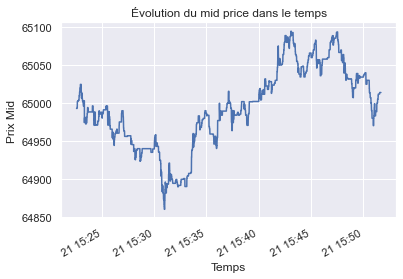

In [11]:
# Evolution temporelle du mid price
df['mid'].plot()
plt.title('Évolution du mid price dans le temps')
plt.xlabel('Temps')
plt.ylabel('Prix Mid')
plt.show()

Le graphique et les statistique ci-dessus montrent l'évolution du mid price du Bitcoin sur une période de temps donnée (~25min), illustrant des fluctuations modérées avec une moyenne de 64 992.36 et un écart-type de 53.06. Les prix oscillent entre 64 860.05 et 65 094.65, indiquant une volatilité présente mais contenue. Les variations de prix, bien que régulières, restent dans une fourchette relativement étroite, ce qui suggère un marché relativement stable avec des réactions rapides aux dynamiques de marché à court terme.

### Ordres passées

Afin de visualiser les données sur les ordres passées, nous passons par le formatage du fichier csv.

In [12]:
def read_trades(path):
    df = pd.read_csv(path)
    df.columns = df.iloc[2]
    df = (
        df.iloc[3:]
        .drop(
            [
                np.nan,
                "result",
                "table",
                "_start",
                "_stop",
                "_measurement",
                "exchange",
                "symbol",
            ],
            axis=1,
        )
        .dropna()
    )
    df["_time"] = pd.to_datetime(df["_time"])#, format="ISO8601")
    df = df.set_index(df["_time"], drop=True)
    df[["price", "quantity"]] = df[["price", "quantity"]].astype(np.float64)
    df = df.drop(["_time"], axis=1)
    return df

trades = read_trades("trades2.csv")
#trades = read_trades("bal-trades.csv")

Visualisation du dataframe "trades" qui nous montre les ordres passées (environ 30 000) en l'espace de 1 heure, avec 4 indicateurs : heure de passage de l'ordre, prix d'éxéction, quantité et sens (achat ou vente)

In [13]:
trades

2                                   price  quantity  side
_time                                                    
2024-04-21 15:24:57.929000+00:00  64988.0     0.001   buy
2024-04-21 15:24:58.754000+00:00  64988.0     0.022   buy
2024-04-21 15:25:00.063000+00:00  64987.9     0.149  sell
2024-04-21 15:25:00.098000+00:00  64988.0     0.022   buy
2024-04-21 15:25:00.936000+00:00  64987.9     0.002  sell
...                                   ...       ...   ...
2024-04-21 16:24:56.712000+00:00  64518.6     0.001  sell
2024-04-21 16:24:56.873000+00:00  64518.7     0.071   buy
2024-04-21 16:24:56.977000+00:00  64518.7     0.050   buy
2024-04-21 16:24:57.094000+00:00  64518.7     0.001   buy
2024-04-21 16:24:57.329000+00:00  64518.6     0.010  sell

[29572 rows x 3 columns]

L'importation des données étant fini, nous vérifions maintenant que nous avons des data pour chaque élément de notre dataframe.

In [14]:
NaN_numbers_trades = trades.isnull().sum()
total_numbers_trades = NaN_numbers_trades.sum()
print(total_numbers_trades)
# pas de valeur manquantees : OK

0


Nous avons donc 0 valeurs manquantes, nous pouvons maintenant passer à l'analyse de notre dataframe.

Nous allons maintenant regarder les statistiques descriptives des ordres passées, de manière générale, et ensuite en séparant les ordres d'achats et de ventes.

In [15]:
# Vision assez globale en regardant les statistiques descriptives des ordres passéées
stats = trades[['price', 'quantity']].describe()

print("Statisques descriptives sur le prix et les quantités:")
print(stats)

# Afficher des informations sur les transactions par côté (buy/sell)
side_counts = trades['side'].value_counts()
print("\n")
print("Réparition du nombre d'achats et ventes passées:")
print(side_counts)

Statisques descriptives sur le prix et les quantités:
2             price      quantity
count  29572.000000  29572.000000
mean   64653.288344      0.057307
std      210.623481      0.228501
min    64380.000000      0.001000
25%    64478.100000      0.004000
50%    64563.900000      0.015000
75%    64821.200000      0.050000
max    65094.700000     18.657000


Réparition du nombre d'achats et ventes passées:
buy     15549
sell    14023
Name: side, dtype: int64


In [16]:
# Vision plus précise, en regardant les statistiques desscriptives pour les achats et ventes

buy_trades = trades[trades['side'] == 'buy']
sell_trades = trades[trades['side'] == 'sell']


buy_stats = buy_trades[['price', 'quantity']].describe()
sell_stats = sell_trades[['price', 'quantity']].describe()

print("Statisques descriptives sur les ordres d'achats:")
print(buy_stats)
print("\n")
# Afficher les statistiques descriptives pour les transactions de type 'sell'
print("Statisques descriptives sur les ordres de ventes:")
print(sell_stats)
print("\n")

Statisques descriptives sur les ordres d'achats:
2             price      quantity
count  15549.000000  15549.000000
mean   64647.128150      0.053034
std      209.023536      0.182354
min    64380.100000      0.001000
25%    64479.900000      0.004000
50%    64550.000000      0.014000
75%    64809.700000      0.050000
max    65094.700000     14.481000


Statisques descriptives sur les ordres de ventes:
2             price      quantity
count  14023.000000  14023.000000
mean   64660.118898      0.062046
std      212.181891      0.270550
min    64380.000000      0.001000
25%    64477.300000      0.004000
50%    64580.800000      0.015000
75%    64834.300000      0.050000
max    65094.600000     18.657000




Les statistiques descriptives des transactions d'achat montrent que le prix moyen des ordres d'achat est de 64 647.13, avec un écart-type de 209.02, ce qui indique une certaine variabilité autour de cette moyenne. Les prix varient entre un minimum de 64 380.10 et un maximum de 65 094.70. La quantité moyenne achetée est de 0.053, avec une variation plus élevée (écart-type de 0.182) et des valeurs allant de 0.001 à 14.481, mais restant assez faible au vu du 3eme quartile qui montre qur ordre achat éxécuté sont pour la plupart autour de 0.05.

Pour les transactions de vente, le prix moyen est légèrement supérieur à 64 660.12, avec un écart-type de 212.18, montrant une variabilité similaire aux achats. Les prix des ventes vont de 64 380.00 à 65 094.60. La quantité moyenne vendue est de 0.062, avec une plus grande variation (écart-type de 0.271) et des quantités allant de 0.001 à 18.657, mais comme pour les ordres d'achats exécutés, une quantité inférieure a 0.05 pour la plupart des ordres de ventes executés.

En résumé, les ordres d'achat et de vente ont des prix moyens et des écart-types similaires, suggérant une cohérence dans le marché. Les quantités échangées montrent une plus grande variabilité, surtout pour les ventes, ce qui peut indiquer des différences dans les stratégies d'achat et de vente des traders.

## Variable target : Next 100 ticks returns


L'objectif de notre projet est la prédiction de rendement des 100 prochains ticks, c'est à dire le mid price dans 100 mises à jour du carnet d'ordre. Notre variable cible est donc le rendement réalisé pour les 100 prochains ticks.

In [17]:
# calcule le rendement des xticks (=100) prochains ticks par un changement de pourcentage
def calculate_next_x_ticks_ret(df: pd.DataFrame, xticks: int) -> pd.Series:
    return df["mid"].pct_change(xticks).shift(-xticks)


# variable stocké dans une série
next_ret = calculate_next_x_ticks_ret(df, 100)
next_ret.describe()
# la variable next_ret represente la variable cible

count    7.108800e+04
mean     4.581088e-07
std      8.553579e-05
min     -4.445945e-04
25%      0.000000e+00
50%      0.000000e+00
75%      2.154375e-05
max      4.452404e-04
Name: mid, dtype: float64

Ces statistiques montrent que les rendements des 100 prochains ticks sont généralement très faibles, avec une moyenne proche de zéro. La distribution des rendements est légèrement asymétrique, avec une majorité de rendements étant nuls ou très proches de zéro, comme indiqué par les premier et deuxième quartiles (25% et 50%) étant tous les deux égales à zéro. Les valeurs extrêmes (min et max) montrent que, bien qu'il y ait des rendements positifs et négatifs, ils restent limités en amplitude, avec des variations maximales de l'ordre de 0.000445 en termes absolus. Cette faible volatilité et les rendements faibles sont typiques dans les marchés très liquides et à haute fréquence où malgré les nombreuses mises à jour du carnet d'ordre, le mid price n'évolue pas forcément.

In [18]:
len(next_ret)
#ok

71188

Concernant le choix de 100, nous avons effectué plusieurs test sur la relation entre nos différentes feature (présentes plus bas) et notre variable cible, le choix de 100 a donc été déterminé en lien avec les différentes relations. De plus, sachant que le bitcoin est une cryptomonnaie liquide, il est difficile de prévoir à long terme. Le marché étant efficient même sur des durée très courte, le seul moyen d'arriver à anticiper des variations est de regarder à un faible nombre de ticks.

In [19]:
df.index.to_series().diff(100).mean()
#df.index.to_series().diff(500).mean()

Timedelta('0 days 00:00:02.454780230')

La prévision de carnet d'ordre pour les 100 prochains ticks a une moyenne d'environ 2.45sec, temps assez pertinent puisqu'il suffit d'un temps beaucoup plus faible pour passer un ordre. Nous avions essayé de mettre une plage de temps supérieur, dans le cas où on augmentait la période à 500, on était à plus de 12sec. Il était tres dur de trouver des features intéréssantes avec ce décalage, d'où une plage réduite, donc plus pertinente.

Nous avons ainsi fait une représentation graphique de notre variable cible.

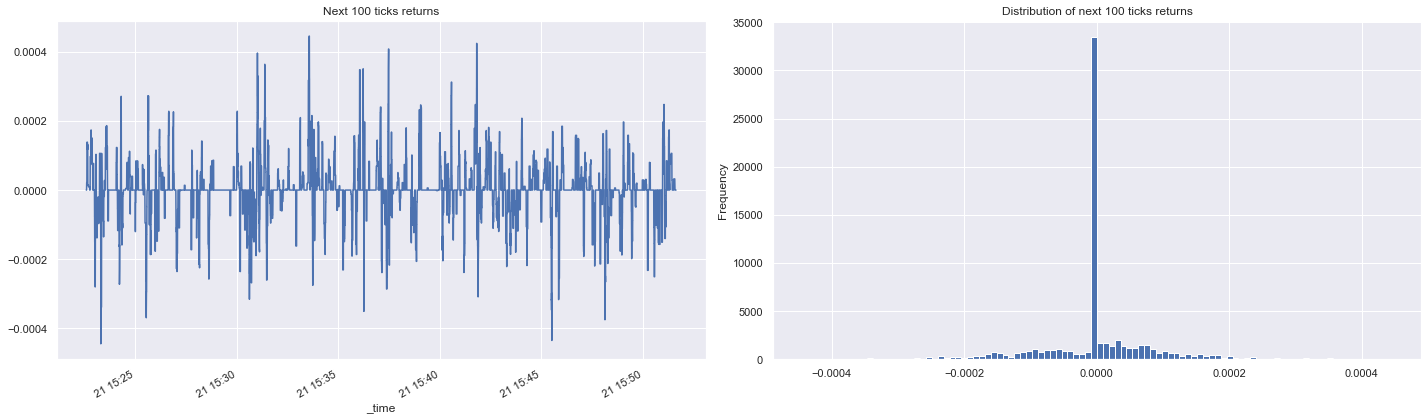

In [20]:
# graph

fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
next_ret.plot(
    ax=ax[0], title="Next 100 ticks returns"
)  # variations des rendements sur le temps

next_ret.plot.hist(
    ax=ax[1], title="Distribution of next 100 ticks returns", bins=100
)  # distribution des rendements

fig.tight_layout()

Nous avons décidé de faire une représentation graphique de notre variable cible, c'est à dire la prévision de rendement des 100 prochains ticks. Sachant que la cryptomonnaie bitcoin est une crypto liquide, il est normal que nos rendements aient une faible volatilités, des variations comprises entre -0.04% et 0.04%, et assez proche de 0 pour la plupart.

Maintenant que nous avons vu notre variable cible, nous devons construire nos features (variables explicatives) afin de converger vers l'objectif du projet.

## Feature 1 : Orderbook Skew


### Description feature 1

Notre première feature nous permet de calculer un indicateur appelé "skew" à partir de notre carnet d'ordre (df). Elle extrait les volumes des offres d'achat et de vente jusqu'à une profondeur spécifiée par l'utilisateur (input "depth"), puis calcule le "skew" en divisant le volume total des offres d'achat par la somme du volume total des offres d'achat et des offres de vente. Cet indicateur peut aider à évaluer la tendance potentielle du marché, avec un "skew" plus élevé indiquant une dominance des offres d'achat et un "skew" plus faible indiquant une dominance des offres de vente. C'est un proxy de l'offre et de la demande potentielle.
<br>
<center>
    <h1>
        $\text{Overbook skew}_{t} =\frac{\sum_{i=0}^{\text{depth}-1} \text{volume bid}_i}{\sum_{i=0}^{\text{depth}-1} (\text{volume bid}_i + \text{volume ask}_i)}$
    </h1>
</center>

In [21]:
# calcul skew
# somme bid_volume / (bid_volume + ask_volume)
# ajout d'un parametre de profondeur
# indicateur pour l'acheteur car il a indication sur la demande dispinible
def calculate_orderbook_skew(df: pd.DataFrame, depth: int) -> pd.Series:

    # extraction des volumes des bid et des ask
    bid_cols = [col for col in df.columns if ("bid" in col) and ("amount" in col)]
    ask_cols = [col for col in df.columns if ("ask" in col) and ("amount" in col)]
    key = lambda x: int(x.split("[")[1].split("]")[0])
    ask_cols.sort(key=key)
    bid_cols.sort(key=key)

    # calcul le volume sur une profondeur allant jusqu'a 'depth'
    bid_amount = df[bid_cols[:depth]].sum(axis=1)
    ask_amount = df[ask_cols[:depth]].sum(axis=1)
    #print(df[ask_cols[:depth]])
    return bid_amount / (bid_amount + ask_amount)


skew = calculate_orderbook_skew(df, 10)
# feature qui pourra etre adapté plusieurs fois dans le modele en modifiant la profondeur (resultat different)
# pour cela il faut changer la valeur 10 dans ka variable skew qui prend la fonction du dessus en compte
# valeur possible : 0 a 50 (= profondeur de marché)

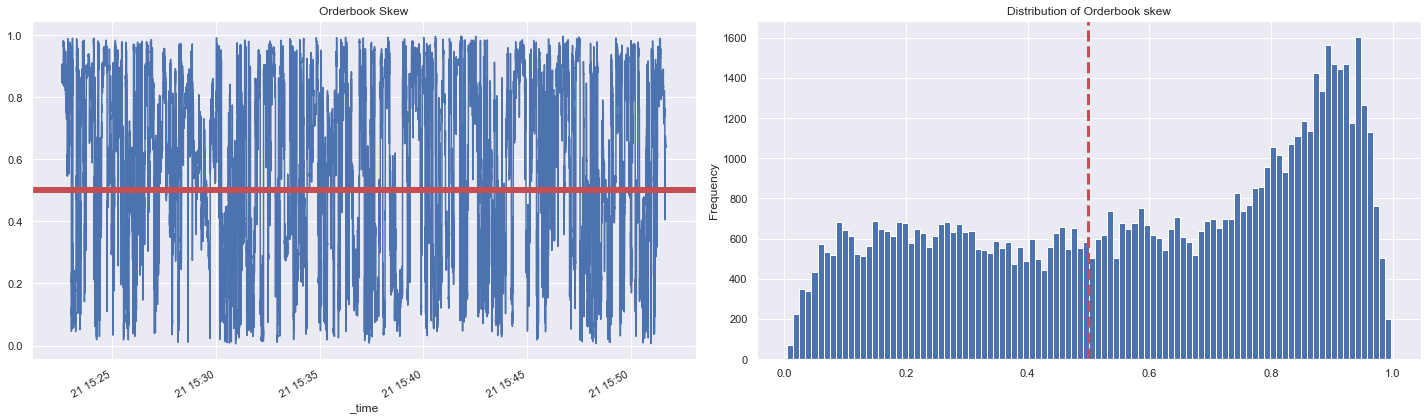

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
skew.plot(ax=ax[0], title="Orderbook Skew")
ax[0].axhline(y=0.5, color='r', linestyle='-', linewidth=6)
skew.plot.hist(ax=ax[1], title="Distribution of Orderbook skew", bins=100)
ax[1].axvline(x=0.5, color='r', linestyle='--', linewidth=3)
fig.tight_layout()

# si > 0.5 : plus de demande
# si < 0.5 : plus d'offre
# indicateur pertinennt sur le marché

Si notre feature skew reste généralement au-dessus de 0.5, cela pourrait indiquer une tendance haussière, avec une dominance des offres d'achat sur le marché. À l'inverse, s'il reste généralement en dessous de 0.5, cela pourrait indiquer une tendance baissière, avec une dominance des offres de vente.

D'après les graphes ci-dessus, pour une profondeur de 10, on peut voir que la pariété sur notre première feature est pas forcément respecté, avec une tendance à la hausse. En effet, notre indicateur varie de 0 à 1, avec une légère tendance pour un surplus de demande comparé à l'offre, et une fréquence assez constante entre 0 et 0.7, et plus forte entre 0.7 et 1.

De plus, la liquidité importante de notre cryptomonnaie implique des variations soudaines et importantes qui pourraient être le signe de changements rapides dans les dynamiques de l'offre et de la demande.

### Effect of orderbook skew on returns


<AxesSubplot:xlabel='skew_bin', ylabel='next_ret'>

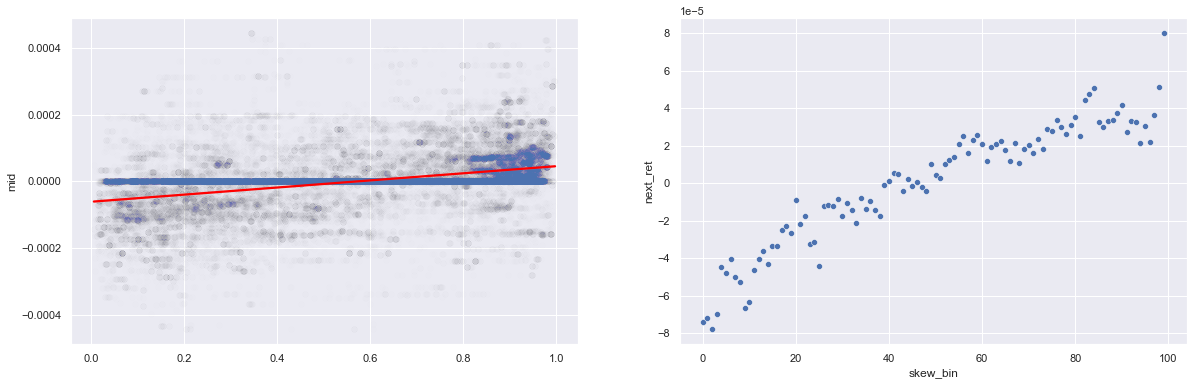

In [23]:
bins = pd.qcut(skew, q=100, labels=False)
combined = pd.concat([bins, next_ret], axis=1)
combined.columns = ["skew_bin", "next_ret"]
mean_ret_per_bin = combined.groupby("skew_bin").mean()

fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
sns.regplot(
    x=skew,
    y=next_ret,
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.005},
    ax=ax[0],
)
sns.scatterplot(
    x=mean_ret_per_bin.index, y=mean_ret_per_bin.squeeze(), ax=ax[1]
)

# gauche : nuage de points avec droite de regression
# droite : ensemble valeur skew, pour chaque valeur, on calcule son quantile
# 100 quartile : 1 er quartile -> 1% des valeurs les plus basses
# 2 eme quartile : [1,2]% des valeurs les plus basses ect...
# resume : valeur moyenne par quantile de 1%

Le graphique de gauche montre la relation entre l'indicateur skew et les rendements futurs des 100 prochains ticks. Chaque point représente une observation individuelle, où l'axe des x indique les valeurs de skew et l'axe des y indique les rendements futurs correspondants. La ligne rouge représente la tendance générale de cette relation. Bien que les points soient dispersés, la ligne de tendance suggère une légère corrélation positive, ce qui signifie que des valeurs plus élevées de la feature tendent à être associées à des rendements futurs plus élevés.

Le graphique de droite présente la moyenne des rendements futurs pour chaque bin de skew. Les bins sont créés en divisant les valeurs de notre feature en 100 quantiles égaux. Chaque point sur ce graphique représente la moyenne des rendements pour un bin spécifique de skew. Ce graphique montre une tendance ascendante, où les rendements moyens augmentent avec les valeurs de notre feature avec les points qui suivent une trajectoire générale vers le haut, indiquant que des niveaux plus elevés de skew sont associés à des rendements futurs plus élevés en moyenne. 

Cette tendance suggère une relation positive entre notre feeature et les rendements futurs, renforçant l'idée que lorsque les volumes des offres d'achat dominent, les rendements futurs tendent à être plus élevés.

## Feature 2 : Rolling trade imbalance

### Description Feature 2

Notre deuxième feature combine les données du carnet d'ordres et des transactions passées pour évaluer le trade imbalance. On suposse alors que si on a pas de nouveau prix ou volume sur une ligne (time), alors on remplit la valeur par sa valeur précédente (méthode "ffill" = forward fill). En effet, il parait assez logique de faire cela car si aucune transaction a eu lieu sur le marché, alors les volumes et prix sont ceux les précédents.

In [24]:
# merge dataframe et cas des valeurs manquantes
trades_book = pd.concat([df, trades], axis=1)
ob_columns = [col for col in trades_book.columns if "." in col] # prend toutes les colonnes du carnet dordre
trades_book[ob_columns] = trades_book[ob_columns].ffill()

Notre deuxième feature calcule le montant total d'achat (prix * quantité) et de vente pour chaque transaction. En utilisant une fenêtre mobile spécifiée (input "rolling_window" = w dans la formule ci dessous), elle évalue le déséquilibre en divisant la somme total des montants d'achat par la somme totale des montants d'achat et de vente sur cette fenêtre. Ce déséquilibre peut fournir des indications sur la direction et l'intensité des transactions passés sur le marché.
<br>


<center>
    <h1>
        $\text{Rolling Trade Imbalance}_{t} = \frac{\sum_{i=0}^{w-1} \text{achat total}_{t-i}}{\sum_{i=0}^{w-1} \text{achat total}_{t-i} + \sum_{i=0}^{w-1} \text{vente total}_{t-i}}$
    <h1>
</center>

In [25]:
# fonction pour calculer la feature 2
def calculate_trade_imbalance(
    trades_book: pd.DataFrame, rolling_window: int
) -> pd.Series:
    
    # achat total et remplace valeur manquantes par 0 
    trades_book["buy_amount"] = (
        trades_book["price"] * trades_book["quantity"] * (trades_book["side"] == "buy")
    ).fillna(0)

    # vente total et remplace valeur manquantes par 0 
    trades_book["sell_amount"] = (
        trades_book["price"] * trades_book["quantity"] * (trades_book["side"] == "sell")
    ).fillna(0)

    # trade inbalance
    trade_imbalance = trades_book["buy_amount"].rolling(rolling_window).sum() / (
        trades_book["buy_amount"].rolling(rolling_window).sum()
        + trades_book["sell_amount"].rolling(rolling_window).sum()
    )

    return trade_imbalance


#rolling_trade_imbalance = calculate_trade_imbalance(trades, 10_000)
rolling_trade_imbalance = calculate_trade_imbalance(trades_book, 50_000)
#rolling_trade_imbalance = calculate_trade_imbalance(merged_df, 50_000)
#rolling_trade_imbalance = calculate_trade_imbalance(df, 10_000)

# feature qui pourra etre adapté plusieurs fois dans le modele en modifiant la rollinf window (resultat different)
# pour cela il faut changer la valeur 10_000 dans la variable rolling_trade_imbalance qui prend 
#la fonction du dessus en compte

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


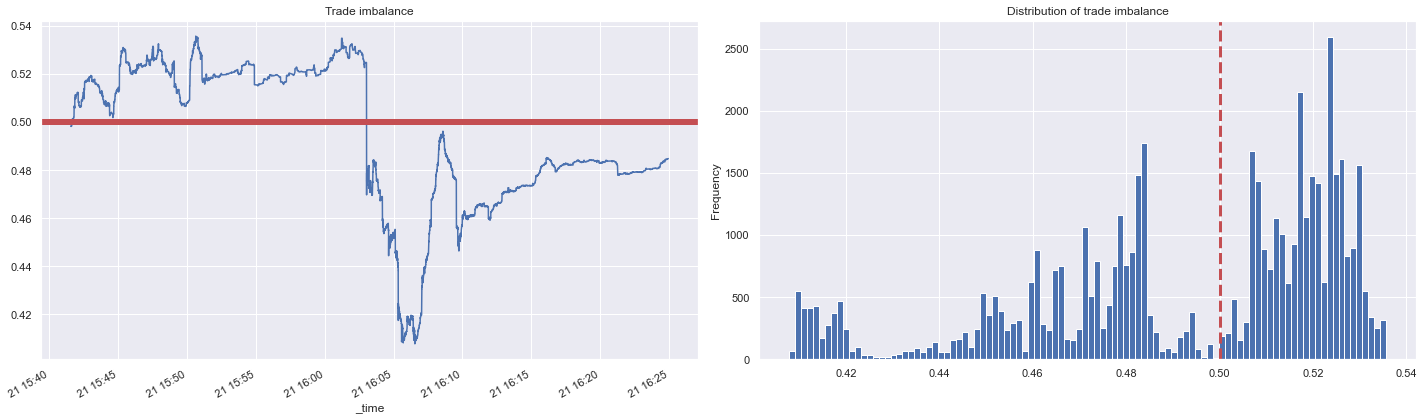

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
rolling_trade_imbalance.plot(ax=ax[0], title="Trade imbalance")
ax[0].axhline(y=0.5, color='r', linestyle='-', linewidth=6)
rolling_trade_imbalance.plot.hist(
    ax=ax[1], title="Distribution of trade imbalance", bins=100
)
ax[1].axvline(x=0.5, color='r', linestyle='--', linewidth=3)
fig.tight_layout()

Ces graphiques offrent une vision claire du déséquilibre des échanges sur le marché pour rolling window = 50000. Le graphique de gauche montre comment ce déséquilibre varie au fil du temps, tandis que l'histogramme de droite permet de visualiser la fréquence des différentes valeurs de déséquilibre. Ensemble, ils indiquent que, bien que le marché soit souvent en équilibre (autour de 0,5), il y a des périodes où les achats ou les ventes dominent, influençant potentiellement les dynamiques du marché et les prix des actifs.

### Effect of trade imbalance  on returns


<AxesSubplot:xlabel='trade_imbalance_bin', ylabel='next_ret'>

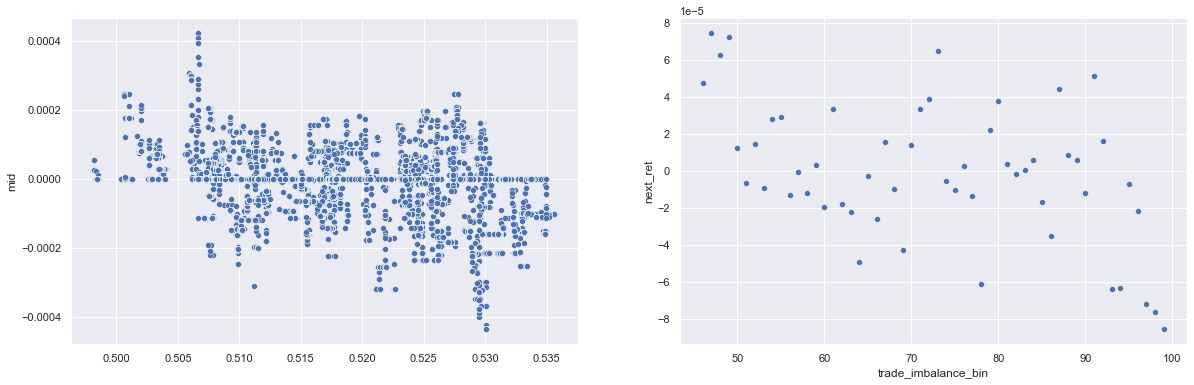

In [27]:
bins = pd.qcut(rolling_trade_imbalance, q=100, labels=False, duplicates="drop")
combined = pd.concat([bins, next_ret], axis=1)
combined.columns = ["trade_imbalance_bin", "next_ret"]
mean_ret_per_bin = combined.groupby("trade_imbalance_bin").mean()
mean_ret_per_bin

fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
sns.scatterplot(
    x=rolling_trade_imbalance, 
    y=next_ret,
    #line_={"color": "red"},
    #scatter_kws={"alpha": 0.005},
    ax=ax[0],
)

sns.scatterplot(
    x=mean_ret_per_bin.index, y=mean_ret_per_bin.squeeze(), ax=ax[1]
)


Ces graphiques montrent une relation bruyante typique des données haute-fréquence entre notre feature et les rendements futurs. Cependant le graphique de droite met en évidence une relation négative entre notre feature et les rendements futurs, indiquant un retour à la moyenne lorsque le marché a subit une proportion d'achats ou de ventes élevés.

# Features 3 : bid ask impress


### Description Feature 3

La troisième feature est conçue pour calculer le "bid ask impress". Cette caractéristique se base sur une analyse des signaux d'achat et de vente ("buy" et "sell") présents dans les données. 

Tout d'abord, nous travaillons sur le dataframe utilisé dans la feature 2, soit "trades_book", et attribuons des valeurs numériques aux signaux d'achat et de vente, avec 1 pour les achats, -1 pour les ventes et 0 pour les autres cas.

Ensuite, on utilise une fenêtre mobile de taille spécifiée (dans ce cas, input "xticks" et w dans la formule du bas) pour calculer la somme cumulée des signaux d'achat et de vente sur cette période. Cette somme cumulée est ensuite normalisée par la somme cumulative absolue des signaux, donnant ainsi une mesure du pourcentage de dominance des achats ou des ventes dans le marché sur la fenêtre mobile spécifiée.


Cette feature est simplement la somme du nombre d'achat moins le nombre de ventes pour une période donnée, divisé par l'activité total, soit le nombre d'ordre executé (signal achat + valeur absolue |signal vente|).

<center>
    <h1>
        $\text{Bid Ask Impress}_{t} = \frac{\sum_{i=0}^{w-1} \text{(signal achat + signal vente)}_{t-i}}{\sum_{i=0}^{w-1} \text{(|signal achat| + |signal vente|)}_{t-i}}$
    <h1>
</center>


In [28]:
# fonction pour attribuer les signaux d"execution
def side_signal(df) -> pd.Series:
     
    # attribue 1 si achat, -1 si vente et 0 sinon
    df["signal"] = df["side"].apply(
        lambda x: 1 if x == "buy" else (-1 if x == "sell" else 0)
    )
    return df

df_signal_1 = side_signal(trades_book)
#df_signal_1 = side_signal(merged_df)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [29]:
# fonction pour calculer le bid ask impress
def calculate_next_x_ticks_signal_rolling_sum(df, xticks: int) -> pd.Series:
    
     # Somme cumulative des signaux d'achat et de vente en mettant des 0 si NaN
    df["rolling_sum"] = df["signal"].rolling(window=xticks).sum().fillna(0)
    
    # Somme cumulative absolue des signaux d'achat et de vente en mettant des 0 si NaN
    df["rolling_sum_absolu"] = df["signal"].abs().rolling(window=xticks).sum().fillna(0)
    
    # ratio
    df["signal_rolling_sum_%"] = (
        df["rolling_sum"] / df["rolling_sum_absolu"].fillna(0)
    )
    
    return df["signal_rolling_sum_%"]

df_signal_2 = calculate_next_x_ticks_signal_rolling_sum(df_signal_1, 1000)
# feature qui pourra etre adapté plusieurs fois dans le modele en modifiant la xticks (resultat different) 1000 de base

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


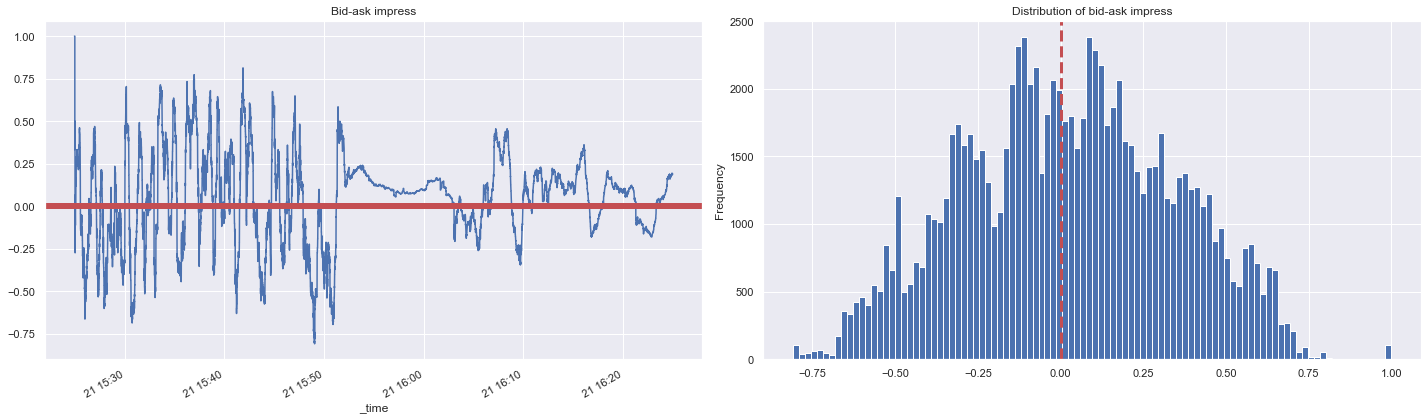

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
df_signal_2.plot(ax=ax[0], title="Bid-ask impress")
ax[0].axhline(y=0, color='r', linestyle='-', linewidth=6)
df_signal_2.plot.hist(
    ax=ax[1], title="Distribution of bid-ask impress", bins=100
)
ax[1].axvline(x=0, color='r', linestyle='--', linewidth=3)
fig.tight_layout()

Lorsque le ratio bid ask Iimpress est supérieur à 0, cela suggère une dominance des signaux d'achat par rapport aux signaux de vente sur le marché. Ce scenario peut indiquer un sentiment positif ou optimiste, avec une demande plus forte pour l'actif financier par rapport à l'offre. Dans ces conditions, on peut s'attendre à une hausse des prix ou à une tendance haussière, alimentée par un intérêt accru des investisseurs à acheter.

En revanche, lorsque le ratio de notre feature est inférieur à 0, cela révèle une dominance des signaux de vente par rapport aux signaux d'achat. Ce scénario peut refléter un sentiment négatif ou pessimiste, avec une offre excédant la demande sur le marché. Dans de telles situations, on peut anticiper une pression à la baisse sur les prix ou une tendance baissière, car les investisseurs sont plus enclins à vendre leurs positions ou à adopter une approche plus prudente.

Le ratio offre des indications importantes sur le sentiment et les dynamiques du marché, en permettant d'évaluer l'équilibre entre l'offre et la demande et d'anticiper les mouvements potentiels des prix.

D'après le graphique ci-dessus, la feature pour un rolling window de 1000 varie de -75% à 100%, avec des fluctuations assez importantes et rapides à travers le temps. On semble observer une certaine parité entre la dominance des signaux d'achat et de vente, bien que les valeurs oscillent souvent autour de zéro, ce qui suggère une alternance régulière entre des périodes de sentiment optimiste et pessimiste.

### Effect of bid ask impress  on returns


<AxesSubplot:xlabel='df_signal_2', ylabel='next_ret'>

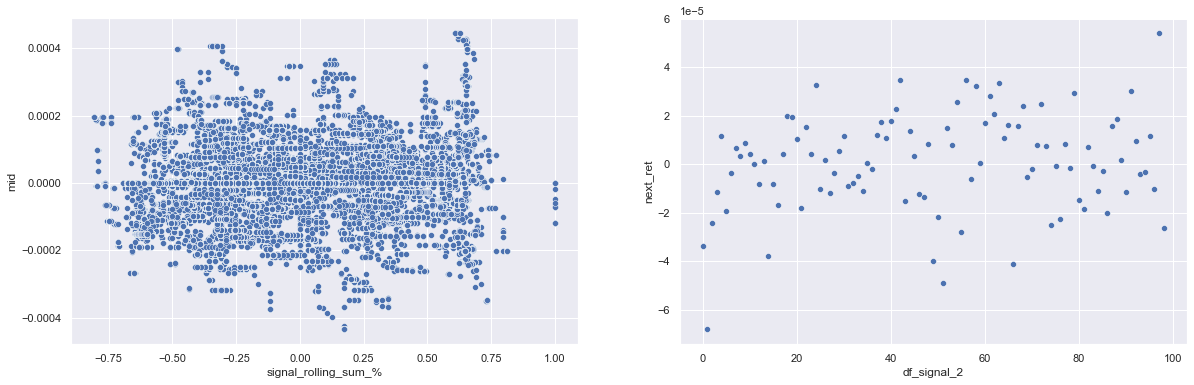

In [31]:
bins = pd.qcut(df_signal_2, q=100, labels=False, duplicates="drop")
combined = pd.concat([bins, next_ret], axis=1)
combined.columns = [ "df_signal_2","next_ret"]
mean_ret_per_bin = combined.groupby("df_signal_2").mean()

fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
sns.scatterplot(
    x=df_signal_2, 
    y=next_ret,
    #line_kws={"color": "red"},
    #scatter_kws={"alpha": 0.005},
    ax=ax[0],
)

sns.scatterplot(
    x=mean_ret_per_bin.index, y=mean_ret_per_bin.squeeze(), ax=ax[1]
)
# plein de trade -> impact sur le prix (baisse du prix en moyenne)

Le  graphique de droite montre la moyenne des rendements par bin de notre feature. Les bins sont créés en divisant les valeurs du bid ask impress en 100 quantiles égaux. Chaque point sur ce graphique représente la moyenne des rendements pour un bin spécifique de la feature. Ce graphique permet de visualiser plus clairement comment les rendements moyens varient en fonction des différents niveaux de bid ask impress. Le graphique montre une dispersion des points sans tendance claire et uniforme, avec les rendements moyens qui varient autour de zéro, sans pattern régulier observable (pas de corrélation évidente)

# Feature 4: layers ob add-cancels


### Description Feature 4

La quatrième feature calcule un indicateur appelé "add cancels" à partir du carnet d'ordres (df). Elle procède en trois étapes principales. Tout d'abord, elle identifie les colonnes correspondant aux volumes des offres d'achat et de vente (bid et ask) et les trie en fonction de leur profondeur. Ensuite, elle calcule la somme des volumes des bid et ask jusqu'à une profondeur spécifiée par l'utilisateur (input "depth"). Enfin, elle retourne le rolling mean de la somme de ces volumes sur une fenêtre de temps spécifiée par l'utilisateur (input "window"). Cette fonction permet d'analyser les ajouts et les annulations d'ordres dans le carnet d'ordres sur une période donnée, offrant ainsi un aperçu de de l'évolution relative de la demande et de l'offre dans le carnet d'ordre.


<center>
    <h1>
        $\text{add_cancels}_{t} = \frac{1}{\text{window}} \sum_{i=0}^{\text{window}-1} [\sum_{j=0}^{\text{depth}-1} \text{(volume ask + volume bid)}_{j}]$
    <h1>
</center>


In [32]:
# fonction pour calculer notre feature
def calculate_add_cancels(df: pd.DataFrame, depth: int, window: int) -> pd.Series:
    bid_cols = [col for col in df.columns if ("bid" in col) and ("amount" in col)]
    ask_cols = [col for col in df.columns if ("ask" in col) and ("amount" in col)]
    key = lambda x: int(x.split("[")[1].split("]")[0])
    ask_cols.sort(key=key)
    bid_cols.sort(key=key)
    bid_amount = df[bid_cols[:depth]].sum(axis=1)
    #print (bid_cols[:depth])
    ask_amount = df[ask_cols[:depth]].sum(axis=1)
    return (bid_amount + ask_amount).rolling(window).mean()

# on stock valeur
add_cancels = calculate_add_cancels(df.diff(), 5, 1_000)
#add_cancels
# feature qui pourra etre adapté plusieurs fois dans le modele en modifiant la xticks (resultat different) 5 1000 de base
# premier input depth represente profondeur du carnet donc de 1 a 50
# deuxieme input represente la window

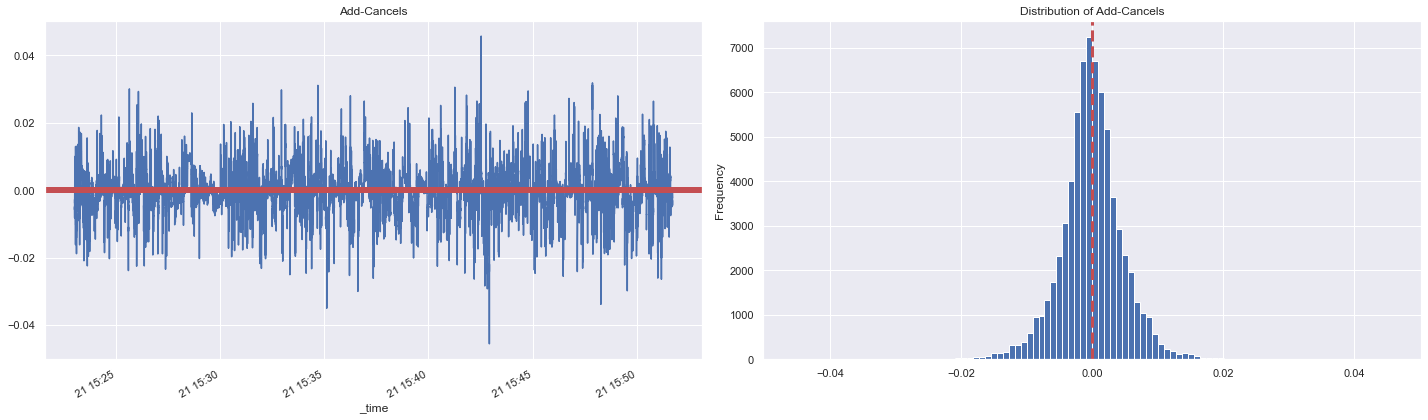

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
add_cancels.plot(ax=ax[0], title="Add-Cancels")
ax[0].axhline(y=0, color='r', linestyle='-', linewidth=6)
add_cancels.plot.hist(ax=ax[1], title="Distribution of Add-Cancels", bins=100)
ax[1].axvline(x=0, color='r', linestyle='--', linewidth=3)
fig.tight_layout()

Ces graphiques fournissent une vision claire de l'activité des ajouts et des annulations d'ordres dans le carnet d'ordres. Le graphique de gauche montre des fluctuations rapides et fréquentes autour de zéro, indiquant une alternance dynamique entre les ajouts et les annulations d'ordres. L'histogramme de droite confirme que ces actions sont généralement équilibrées, avec une forte concentration de valeurs autour de zéro. Ensemble, ces graphiques montrent que le marché est actif et que notre feature peut être utilisé pour suivre et analyser la liquidité et l'activité du marché en temps réel.


### Effect of layers obb add-cancels on returns


<AxesSubplot:xlabel='add_cancels_bin', ylabel='next_ret'>

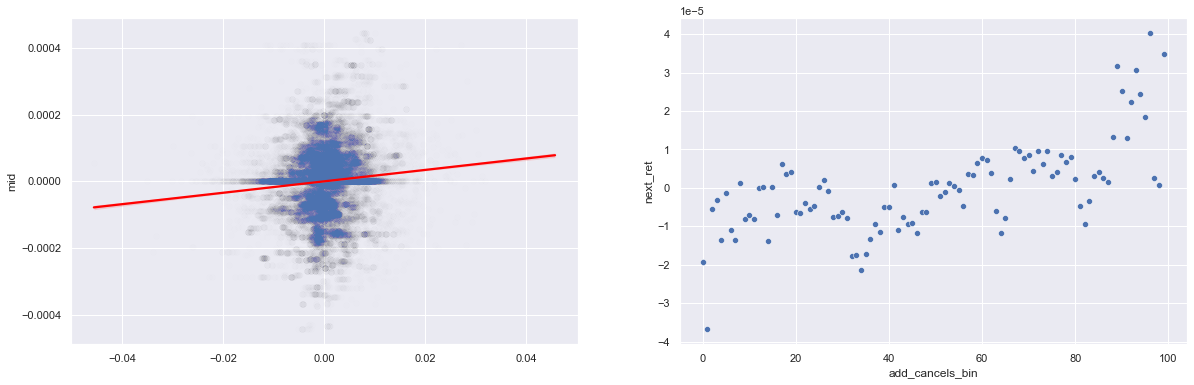

In [34]:
bins = pd.qcut(add_cancels, q=100, labels=False)
combined = pd.concat([bins, next_ret], axis=1)
combined.columns = ["add_cancels_bin", "next_ret"]
mean_ret_per_bin = combined.groupby("add_cancels_bin").mean()

fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
sns.regplot(
    x=add_cancels,
    y=next_ret,
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.005},
    ax=ax[0],
)

sns.scatterplot(
    x=mean_ret_per_bin.index, y=mean_ret_per_bin.squeeze(), ax=ax[1]
)

Ces graphiques montrent une relation positive entre notre feature et les rendements futurs. Le graphique de gauche, avec la ligne de tendance rouge, suggère une légère corrélation positive entre l'activité d'ajouts et d'annulations d'ordres et les rendements futurs. Le graphique de droite, qui montre les moyennes des rendements par bin de la feature, confirme cette tendance avec une trajectoire ascendante claire. Ces observations indiquent que des niveaux plus élevés de notre feature sont associés à des rendements futurs plus élevés, suggérant que cet indicateur peut être utile pour anticiper les mouvements futurs des prix sur le marché. Il faut cependant noter que cette relation n'est pas linéaire et se concentre sur les queues de distribution.

# Feature 5: Distance mid - moving average


### Description Feature 5

Cette feature calcule la différence entre le mid price et sa moyenne mobile sur une fenêtre spécifié (input "window"). Elle nous permet donc d'identifier les moments où le prix actuel s'écarte de manière significative de sa tendance moyenne sur le long terme. On peut la considérer comme un effet de momentum, avec signal d'achat si le mid price est supérieur à la moyenne mobile.
<br>

<center>
    <h1>
        $\text{buy signal}_{t} = \text{mid price}_{t} - \frac{1}{\text{window}} \sum_{i=0}^{\text{window}-1} \text{mid price}_{t-i}$
    <h1>
</center>

In [35]:
def buy_signal_with_movingaverage (df:pd. DataFrame, window:int) -> pd.Series:
    df['moving_average']=df['mid'].rolling(window=window).mean()
    df["prev_moving_average"]=df['moving_average']
    df['signal'] = (df["mid"]- df["prev_moving_average"])
    return df['signal']

result_signal_achat = buy_signal_with_movingaverage (df, 200)

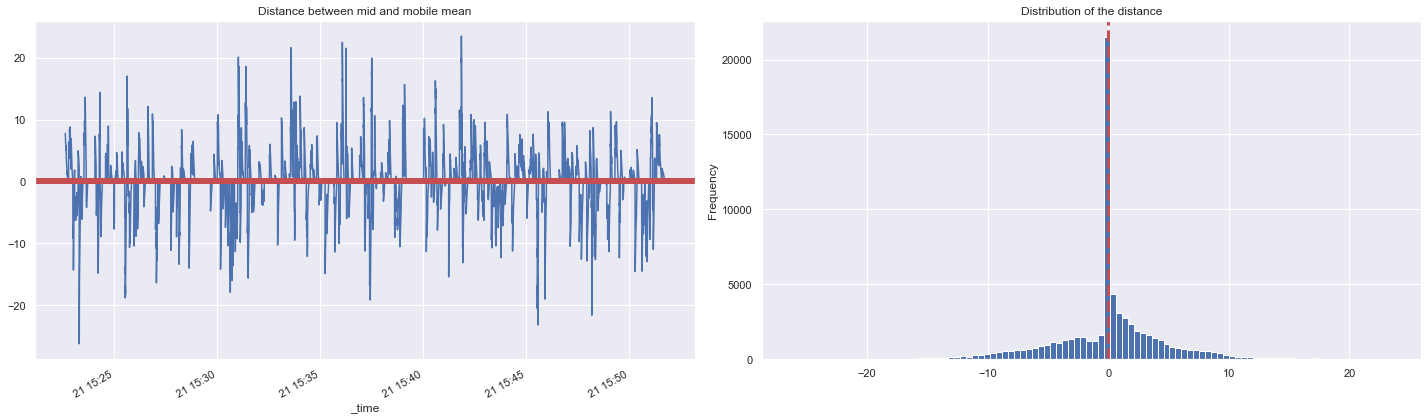

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
result_signal_achat.plot(ax=ax[0], title="Distance between mid and mobile mean")
ax[0].axhline(y=0, color='r', linestyle='-', linewidth=6)
result_signal_achat.plot.hist(ax=ax[1], title="Distribution of the distance", bins=100)
ax[1].axvline(x=0, color='r', linestyle='--', linewidth=3)
fig.tight_layout()

Le premier graphe à gauche montre la distance entre le mid price et sa moyenne mobile sur une période spécifiée, en fonction du temps. La ligne rouge horizontale indique un écart nul, servant de référence pour identifier les écarts significatifs. Le second graphe à droite illustre la distribution de cette distance sous forme d'histogramme. La ligne rouge verticale représente un écart nul, permettant de visualiser la fréquence des écarts positifs et négatifs par rapport à la moyenne mobile, avec une parieté qui semble être respecté, comme nous indique aussi le premier graphe.

### Effect of distance between mid & moving average on returns


In [37]:
#ajout d'un petit bruit pour éviter redondances dans nos bins
noise = np.random.normal(0, 1e-25, size=result_signal_achat.shape)
result_signal_achat_noisy = result_signal_achat + noise

<AxesSubplot:xlabel='distance_bin', ylabel='next_ret'>

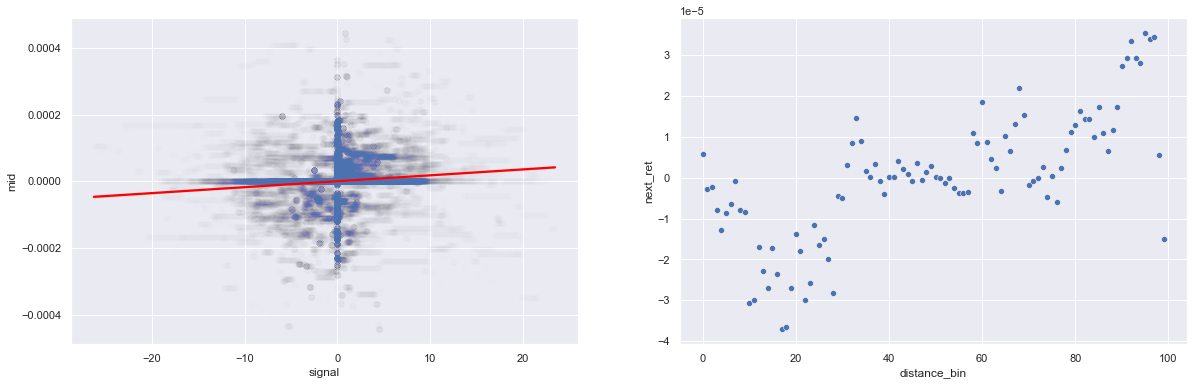

In [38]:
bins = pd.qcut(result_signal_achat_noisy, q=100, labels=False)
combined = pd.concat([bins, next_ret], axis=1)
combined.columns = ["distance_bin", "next_ret"]
mean_ret_per_bin = combined.groupby("distance_bin").mean()

fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
sns.regplot(
    x=result_signal_achat_noisy,
    y=next_ret,
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.005},
    ax=ax[0],
)

sns.scatterplot(
    x=mean_ret_per_bin.index, y=mean_ret_per_bin.squeeze(), ax=ax[1]
)

Le premier graphique à gauche montre un nuage de points (scatter plot) illustrant la relation entre le signal de l'écart par rapport à la moyenne mobile et le mid price, avec une régression linéaire en rouge indiquant la tendance générale, qui semble indiquer une relation positive entre les signaux d'achats et le rendmeent futures. Le nuage de points est légèrement bruité pour éviter les redondances. Le deuxième graphique à droite montre la moyenne des rendements futures pour chaque bin de distance entre mid et moyenne mobile, qui nous permet de visualiser comment les retours moyens varient en fonction des différentes distances bin, et qui confirme une relation positive (comme vu dans graphe de gauche), avec donc un signal d'achat positif qui implique un rendement plus grand..

In [39]:
print(df.index.to_series().diff(100).mean())
print(df.index.to_series().diff(200).mean())
print(df.index.to_series().diff(500).mean())

0 days 00:00:02.454780230
0 days 00:00:04.906887755
0 days 00:00:12.250381097


## Formatting data with features


Nous avons donc construis 5 features, qu'on peut ensuite modifier via les paramètres présent dans nos fonctions. Après de nombreux test, nous avons ajouté des sous features aux features principales, mais aussi exclu la feature 2 sur le trade inbalance qui nous servait que très peu.

In [40]:
feature_1 = [
    pd.Series(calculate_orderbook_skew(df, depth), name=f"ob_skew_{depth}")
    for depth in [1, 25, 50]
] #for depth in [1, 2, 5, 10, 25, 40, 50]

#feature_2 = [
#     pd.Series(
#         calculate_trade_imbalance(trades_book, window),
#         name=f"trade_imbalance_{window}",
#     )
#     for window in [500, 1000, 5000, 10_000]
# ]

# après plusieurs test, nous nous sommes rendu compte que cette feature n'était pas très intéréssante

feature_3 = [
    pd.Series(
        calculate_next_x_ticks_signal_rolling_sum(df_signal_1, window),
        name=f"bid_ask_count_{window}",
    )
    for window in [50, 100, 500]
]

feature_4 = [
    pd.Series(
        calculate_add_cancels(df.diff(), depth, window),
        name=f"add_cancels_{depth}_{window}",
    )
    for depth, window in [(50, 500), (5, 2000), (5, 1000)]
]



feature_5 = [
    pd.Series(
        buy_signal_with_movingaverage(df,window),
        name=f"buy_signal_distance_{window}",
    )
    for window in [100,200,500]
]

# pd.DataFrame(feature_2).T.plot()

On construit maintenant notre dataframe "data" qui contient l'ensemble de nos 12 features, ainsi que notre variable cible.

In [41]:
data = (
    pd.concat(
        [
            pd.DataFrame(feature_1).T,
            # pd.DataFrame(feature_2).T,
            pd.DataFrame(feature_3).T,
            pd.DataFrame(feature_4).T,
            pd.DataFrame(feature_5).T,
            next_ret.round(5)
        ],
        axis=1,
    )
    .sort_index()
    .loc[: df.index[-1]]
    .ffill()
    .dropna()
    .rename(columns={"mid": "next_ret"})
)

data

ob_skew_1  ob_skew_25  ob_skew_50  \
_time                                                                 
2024-04-21 15:24:57.929000+00:00   0.342825    0.465704    0.461378   
2024-04-21 15:24:57.947000+00:00   0.342954    0.465753    0.484953   
2024-04-21 15:24:57.967000+00:00   0.342954    0.474427    0.461419   
2024-04-21 15:24:57.986000+00:00   0.342954    0.496600    0.485558   
2024-04-21 15:24:58.006000+00:00   0.342954    0.457492    0.467374   
...                                     ...         ...         ...   
2024-04-21 15:51:42.547000+00:00   0.589594    0.583613    0.607880   
2024-04-21 15:51:42.626000+00:00   0.589594    0.564025    0.599695   
2024-04-21 15:51:42.686000+00:00   0.589594    0.564473    0.599900   
2024-04-21 15:51:42.707000+00:00   0.589594    0.564025    0.599695   
2024-04-21 15:51:42.747000+00:00   0.589594    0.582265    0.609172   

                                  bid_ask_count_50  bid_ask_count_100  \
_time                                                                   
2024-04-21 15:24:57.929000+00:00               1.0           1.000000   
2024-04-21 15:24:57.947000+00:00               1.0           1.000000   
2024-04-21 15:24:57.967000+00:00               1.0           1.000000   
2024-04-21 15:24:57.986000+00:00               1.0           1.000000   
2024-04-21 15:24:58.006000+00:00               1.0           1.000000   
...                                            ...                ...   
2024-04-21 15:51:42.547000+00:00              -1.0           0.333333   
2024-04-21 15:51:42.626000+00:00              -1.0           0.333333   
2024-04-21 15:51:42.686000+00:00              -1.0           0.333333   
2024-04-21 15:51:42.707000+00:00              -1.0           0.333333   
2024-04-21 15:51:42.747000+00:00              -1.0           0.333333   

                                  bid_ask_count_500  add_cancels_50_500  \
_time                                                                     
2024-04-21 15:24:57.929000+00:00           1.000000           -0.017544   
2024-04-21 15:24:57.947000+00:00           1.000000           -0.013424   
2024-04-21 15:24:57.967000+00:00           1.000000           -0.015968   
2024-04-21 15:24:57.986000+00:00           1.000000           -0.014724   
2024-04-21 15:24:58.006000+00:00           1.000000           -0.015318   
...                                             ...                 ...   
2024-04-21 15:51:42.547000+00:00           0.142857           -0.009744   
2024-04-21 15:51:42.626000+00:00           0.142857           -0.011580   
2024-04-21 15:51:42.686000+00:00           0.142857           -0.012178   
2024-04-21 15:51:42.707000+00:00           0.142857           -0.011196   
2024-04-21 15:51:42.747000+00:00           0.142857           -0.010524   

                                  add_cancels_5_2000  add_cancels_5_1000  \
_time                                                                      
2024-04-21 15:24:57.929000+00:00           -0.001180           -0.009260   
2024-04-21 15:24:57.947000+00:00           -0.000868           -0.009261   
2024-04-21 15:24:57.967000+00:00           -0.000502           -0.007169   
2024-04-21 15:24:57.986000+00:00           -0.000573           -0.007024   
2024-04-21 15:24:58.006000+00:00           -0.000573           -0.007024   
...                                              ...                 ...   
2024-04-21 15:51:42.547000+00:00           -0.002391           -0.001040   
2024-04-21 15:51:42.626000+00:00           -0.002391           -0.004511   
2024-04-21 15:51:42.686000+00:00           -0.002391           -0.003139   
2024-04-21 15:51:42.707000+00:00           -0.002391           -0.003163   
2024-04-21 15:51:42.747000+00:00           -0.002391           -0.003063   

                                  buy_signal_distance_100  \
_time                                                       
2024-04-21 15:24:57.929000+00:00             0.000000e+00   
2024-04-21 1

In [42]:
data.describe()

ob_skew_1    ob_skew_25    ob_skew_50  bid_ask_count_50  \
count  69514.000000  69514.000000  69514.000000      69514.000000   
mean       0.570228      0.557380      0.523102          0.021131   
std        0.364332      0.217926      0.139053          0.798952   
min        0.000072      0.026365      0.079274         -1.000000   
25%        0.188891      0.383505      0.424478         -1.000000   
50%        0.651311      0.575072      0.528797          0.000000   
75%        0.930419      0.746843      0.626576          1.000000   
max        0.999941      0.984354      0.931268          1.000000   

       bid_ask_count_100  bid_ask_count_500  add_cancels_50_500  \
count       69514.000000       69514.000000        69514.000000   
mean            0.022857           0.015105            0.000292   
std             0.638522           0.421904            0.021550   
min            -1.000000          -1.000000           -0.171624   
25%            -0.500000          -0.333333           -0.010412   
50%             0.000000           0.000000           -0.000197   
75%             0.500000           0.351351            0.011330   
max             1.000000           1.000000            0.192302   

       add_cancels_5_2000  add_cancels_5_1000  buy_signal_distance_100  \
count        69514.000000        6.951400e+04             6.951400e+04   
mean             0.000065        1.363449e-04             2.234942e-02   
std              0.002504        4.875394e-03             3.125908e+00   
min             -0.022451       -4.558100e-02            -1.882750e+01   
25%             -0.001342       -2.414000e-03            -7.275958e-12   
50%             -0.000050        5.000000e-07             0.000000e+00   
75%              0.001460        2.686000e-03             4.440000e-01   
max              0.022318        4.574200e-02             2.030350e+01   

       buy_signal_distance_200  buy_signal_distance_500      next_ret  
count             69514.000000             6.951400e+04  6.951400e+04  
mean                  0.044138             1.108361e-01  6.552637e-07  
std                   4.712748             7.609593e+00  8.723021e-05  
min                 -23.206750            -2.931750e+01 -4.300000e-04  
25%                  -1.397062            -3.977000e+00  0.000000e+00  
50%                   0.000000             7.275958e-12  0.000000e+00  
75%                   1.791563             4.199375e+00  2.000000e-05  
max                  23.471250             3.473940e+01  4.500000e-04

Les features montrent une large gamme de distributions et de variabilités. Les indicateurs de carnet d'ordres (ob_skew, bid_ask_count) montrent une dominance variable des signaux d'achat et de vente, tandis que l'indicateur d'activité du marché (add_cancels) montre un équilibre général entre les ajouts et les annulations d'ordres. Concernant les signaux d'achats avec moyenne mobile, on observe des tendances avec une certaine parieté autour de 0. Enfin les rendements futurs (next_ret) sont principalement équilibrés autour de zéro, indiquant une volatilité minimale à court terme.

In [43]:
nb_NaN = data.isnull().sum()
sum_nb_NaN = nb_NaN.sum()
print(sum_nb_NaN)

0


Aucune valeur nulle dans notre dataframe avec feature + variables target -> OK

Nous allons maintenant nous intéresser la matrice de corrélation de nos features et variable cible.

<AxesSubplot:>

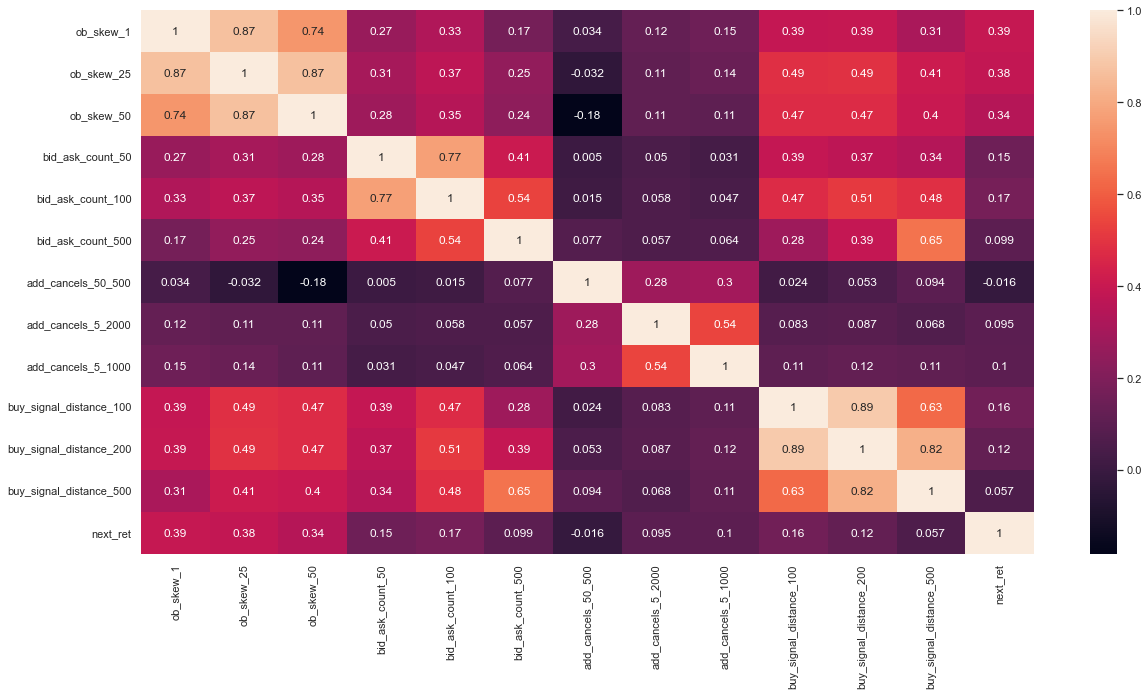

In [44]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True)

Tout d'abord, on peut observer que la quasi entiéreté de nos coefficients de corrélation sont posiitfs. La matrice de corrélation révèle que les ob_skew ont une relation modérément positive avec les rendements futurs, mais aussi entre eux et avec les autres features exceptés add_cancels_50_500. Tandis que les 3 autres features montrent des corrélations plus faibles avec next_ret, et modérées entre sous features (corrélation entre 0.63 et 0.89 concernant nos signaux d'achats via distance mid et moyenne mobile). Les corrélations inter-features suggèrent également des interactions intéressantes entre certaines measures d'activité de marché et la structure du carnet d'ordres.

# Train test split & normalize data

On va donc maintenant spliter nos data dans quatre dataframes différents :

    - X_train qui contient 70% du dataframe "data" des features
    - X_test qui contient 30% du dataframe "data" des features
    - y_train qui contient 70% du dataframe "data" de la variable cible
    - y_test qui contient 30% du dataframe "data" de la variable cible

On definit d'abord la variable xcols comme l'ensemble des colonnes des features

In [45]:
xcols = list(data.columns)
xcols.remove("next_ret")
print(xcols)
print(len(xcols)) 
# prend en compte uniquement les colonnes des features
# ok bien les 12 features

['ob_skew_1', 'ob_skew_25', 'ob_skew_50', 'bid_ask_count_50', 'bid_ask_count_100', 'bid_ask_count_500', 'add_cancels_50_500', 'add_cancels_5_2000', 'add_cancels_5_1000', 'buy_signal_distance_100', 'buy_signal_distance_200', 'buy_signal_distance_500']
12


On définit alors X comme les variables explicatives (features) et y comme la variable cible (target)

In [46]:
X = data[xcols]
y = data["next_ret"]
#X
#y

Second moyen de regarder corrélation entre features

array([[<AxesSubplot:xlabel='ob_skew_1', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='ob_skew_25', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='ob_skew_50', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='bid_ask_count_50', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='bid_ask_count_100', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='bid_ask_count_500', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='add_cancels_50_500', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='add_cancels_5_2000', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='add_cancels_5_1000', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='buy_signal_distance_100', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='buy_signal_distance_200', ylabel='ob_skew_1'>,
        <AxesSubplot:xlabel='buy_signal_distance_500', ylabel='ob_skew_1'>],
       [<AxesSubplot:xlabel='ob_skew_1', ylabel='ob_skew_25'>,
        <AxesSubplot:xlabel='ob_skew_25', ylabel='ob_skew_25'>,
        <AxesSubplot:xlabel='ob_sk

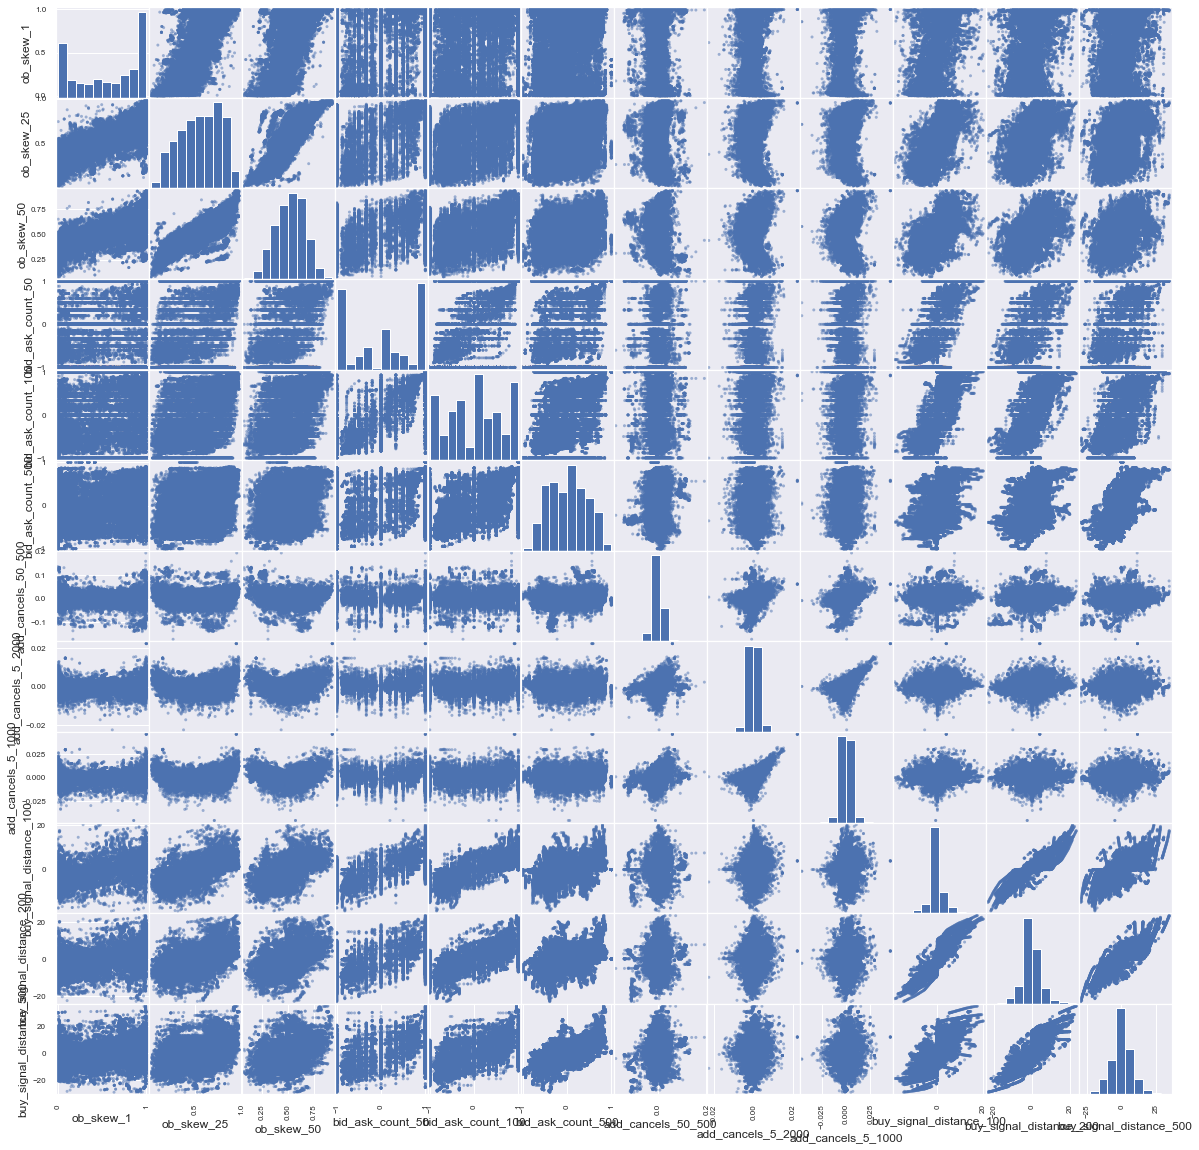

In [47]:
pd.plotting.scatter_matrix(X,figsize=(20,20))

Auparavant, nous passions par la fonction train_test_split en activant le shuffle des données.

Finalement pour éviter l'overfiting , nous avons décidé de couper notre échantillon par les 70% premières valeurs dans le train et les 30% restant dans le test. En effet, nous avions des R2 qui pouvaient atteindre les 40% (modèle DGB) dû à un overfiting du modèle. De plus, sachant que nous travaillons avec des timeseries, cela fait plus de sens de répartir les deux sets par leur temps car la division des time series garantit que les ensembles de test sont plus récents que les ensembles d'entraînement, ce qui est plus réaliste puisque nous ne pourrons pas nous entraîner sur des données "futures".

In [48]:
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 272)

# évitons oferting et trions par date
train_index = int(len(data) * 0.7)
X_train = X.iloc[:train_index]
X_test = X.iloc[train_index:]
y_train = y.iloc[:train_index]
y_test = y.iloc[train_index:]
print('X_train.shape =',X_train.shape)
print ('X_test.shape =',X_test.shape)
print ('y_train.shape =',y_train.shape)
print ('y_test.shape =',y_test.shape)

X_train.shape = (48659, 12)
X_test.shape = (20855, 12)
y_train.shape = (48659,)
y_test.shape = (20855,)


On va normaliser les features, donc les redimensionner afin qu'elles se situent dans une plage de données entre 0 et 1.

In [49]:
# scaler = QuantileTransformer(n_quantiles=100)
scaler = MinMaxScaler()
X_train.loc[:,xcols] = scaler.fit_transform(X_train)
X_test.loc[:,xcols] = scaler.transform(X_test)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Représentation graphique des deux échantillons normalisés

<AxesSubplot:xlabel='_time'>

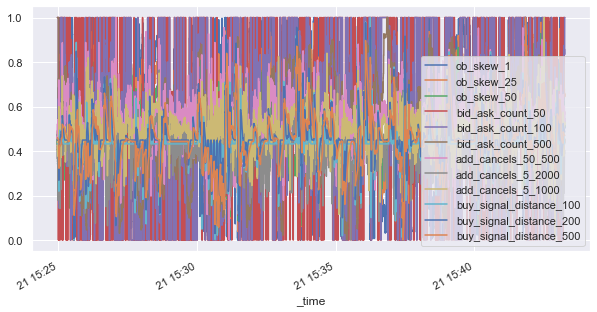

In [50]:
X_train.plot(figsize=(10, 5))

<AxesSubplot:xlabel='_time'>

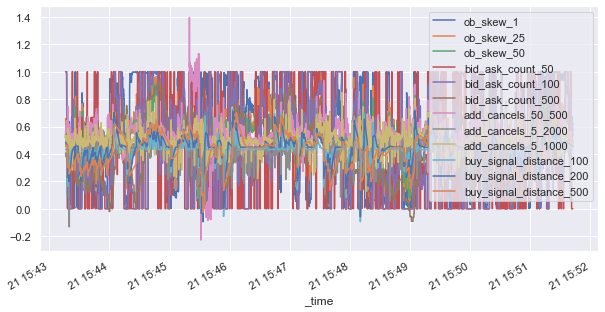

In [51]:
X_test.plot(figsize=(10, 5))

On peut voir que nos variables semblents stationnaires mais évoluent avec une "vélocitée différent". Certaines variables semblent apporter une information à court terme et d'autres à long terme, on pourrait faire le parralèle avec une sorte de régime. Nous esperons que les modèles non-linéaires pourront assimiler ces intéractions.

On converti alors nos quatres dataframes sous forme de pickle pour simplifier la suite du projet.

In [52]:
X_train.to_pickle("X_train.pkl")
X_test.to_pickle("X_test.pkl")
y_train.to_pickle("y_train.pkl")
y_test.to_pickle("y_test.pkl")

## Data train & test

Lecture des pickles train et test qui vont nous permettre de construire nos modèles.

In [53]:
X_train_pkl =pd.read_pickle("X_train.pkl")
X_test_pkl =pd.read_pickle("X_test.pkl")
y_train_pkl =pd.read_pickle("y_train.pkl")
y_test_pkl =pd.read_pickle("y_test.pkl")

Nous allons donc maintenant pouvoir construire nos différents modèles.

## Modèle de Machine Learning

### Modèle de référence - benchmark : MCO

La méthode des moindres carrés oordinaires (OLS) est une technique utilisée pour estimer les paramètres d'un modèle linéaire en minimisant la somme des carrés des différences entre les valeurs observées et les valeurs prédites par le modèle. En effet, elle trouve la ligne qui minimise la distance verticale entre les points de données et la ligne de régression.

R2 MCO: 19.7622%
RMSE MCO: 0.0000767352
AIC: 55088.52295624088
BIC: 55191.81249332708


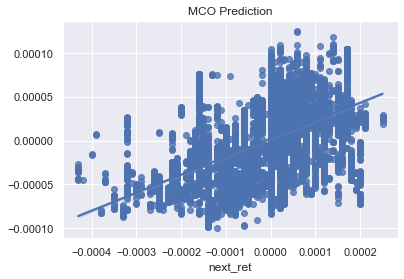

In [54]:
model_MCO = linear_model.LinearRegression().fit(X_train_pkl,y_train_pkl)
y_pred_MCO = model_MCO.predict(X_test_pkl)
r2_MCO = model_MCO.score(X_test_pkl, y_test_pkl) *100
rmse_MCO = math.sqrt(mean_squared_error(y_test_pkl,y_pred_MCO)) 
n_obs = len(y_test_pkl)
n_features = len(X_test_pkl.columns)
log_likelihood_MCO = -0.5 * n_obs * np.log(2 * np.pi) - 0.5 * n_obs * (1 - r2_MCO/100)
AIC_MCO = 2 * (n_features + 1) - 2 * log_likelihood_MCO
BIC_MCO = np.log(n_obs) * (n_features + 1) - 2 * log_likelihood_MCO


ax = sns.regplot(x=y_test_pkl, y=y_pred_MCO)
ax.set_title("MCO Prediction")


print(f"R2 MCO: {r2_MCO:.4f}%")
print(f"RMSE MCO: {rmse_MCO:.10f}")
print("AIC:", AIC_MCO)
print("BIC:", BIC_MCO)

Nous avons obtenu un R2 d'un peu plus de 19.5%, ce qui nous permet de dire que notre modèle est "assez" bien expliqué par les variables explicatives. Concernant la RMSE (racine de l'erreur quadratique moyenne), elle est de 7.7 * 10^(-4), qui est aussi assez faible et permet de dire que notre ajustement semble correct.

Nous allons maintenant interpréter les coefficients.

<AxesSubplot:title={'center':'MCO Coef'}>

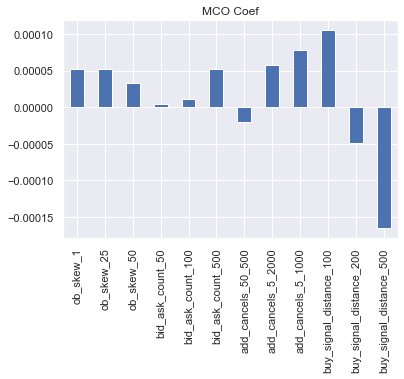

In [55]:
pd.Series(model_MCO.coef_, model_MCO.feature_names_in_).plot.bar(title="MCO Coef")

Concernant les features, les distance 100 et 500 sont plus significatives de l'ensemble des features, jouant respectivement un role positif et negative. Ensuite les variables ob_skew sont quant à elles nettement mois significatives mais jouent un rôle positif. Tandis que les features sur les bid ask count sont assez marginales, ayant un impact positif. Enfin, les features add cancel jouent un rôle significatif et positif.

### Modele non supervisé

Un modèle non supervisé est un algorithme d'apprentissage qui cherche à extraire des informations utiles à partir de données d'entrée sans la présence de sortie correspondantes (variable cible). Comme dit dans l'introduction , cela n'est pas forcément l'objectif de notre projet sachant qu'on cherche à estimer des rendements. En effet, les modèles non supervisés identifient des schémas, des structures ou des relations intrinsèques dans les données sans orientation prédéfinie.

#### PCA

La PCA (analyse en composantes principales) est une technique de réduction de dimension largement utilisée en apppprentissage automatique non supervisé. L'objectif de la PCA est de transformer les features en un nouvel espace de variables, appelées composantes principales, qui capturent la variance maximale des données. Cela permet de réduire la dimension des données tout en conservant autant que possible l'information importante. Ce modèle identifie les directions dans lesquelles les données varient le plus et projette les données dans un espace de dimension inférieure en préservant cette variation maximale. L'interêt principal d'appliquer la PCA avant la régression est la création de composantes principales complètement décorrélés entre-elles. 

<AxesSubplot:title={'center':'Explained Variance'}>

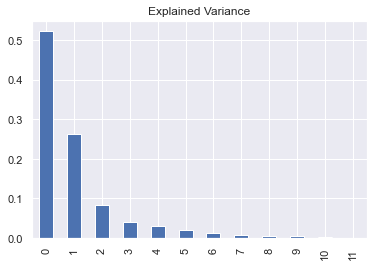

In [56]:
pca = decomposition.PCA()
scores = pd.DataFrame(pca.fit_transform(X_train_pkl), index=X_train_pkl.index)
test_scores = pd.DataFrame(pca.transform(X_test_pkl), index=X_test_pkl.index)
pd.Series(pca.explained_variance_ratio_).plot.bar(title="Explained Variance")

Le graphique de variance expliquée montre la proportion de la variance totale capturée par chaque composante principale du PCA. La première composante principale capture plus de 50 % de la variance totale, indiquant qu'elle est la plus informative en termes de variabilité des données. La deuxième composante principale capture environ 25 % de la variance totale, tandis que les composantes suivantes (au dessus de 3) capturent des proportions décroissantes de variance, chacune contribuant de moins en moins à la variabilité globale des données. Ce graphique suggère que les deux premières composantes principales suffisent à expliquer une grande partie de la variance des données.

R2 PCA: 19.7622%
RMSE PCA: 0.0000767352
AIC: 55088.52295624088
BIC: 55191.81249332708


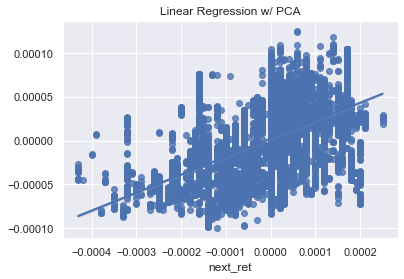

In [57]:
model_PCA = linear_model.LinearRegression().fit(scores, y_train_pkl)
y_pred_PCA = model_PCA.predict(test_scores)
r2_PCA = model_PCA.score(test_scores, y_test_pkl) *100
rmse_PCA = math.sqrt(mean_squared_error(y_test_pkl,y_pred_PCA)) 

n_obs = len(y_test_pkl)
n_features = len(X_test_pkl.columns)
log_likelihood_PCA = -0.5 * n_obs * np.log(2 * np.pi) - 0.5 * n_obs * (1 - r2_PCA/100)
AIC_PCA = 2 * (n_features + 1) - 2 * log_likelihood_PCA
BIC_PCA = np.log(n_obs) * (n_features + 1) - 2 * log_likelihood_PCA
ax = sns.regplot(x=y_test_pkl, y=y_pred_PCA)
ax.set_title("Linear Regression w/ PCA")


print(f"R2 PCA: {r2_PCA:.4f}%")
print(f"RMSE PCA: {rmse_PCA:.10f}")
print("AIC:", AIC_PCA)
print("BIC:", BIC_PCA)

Nous avons obtenu un R2 d'un peu plus de 19.5%, ce qui nous permet de dire que notre modèle est "assez" bien expliqué par les variables explicatives. Concernant la RMSE (racine de l'erreur quadratique moyenne), elle est de 7.7 * 10^(-4), qui est aussi assez faible et permet de dire que notre ajustement semble correct.

### Modele supervisé

Les modèles supervisés sont des algorithmes d'apprentissage automatique conçus pour apprendre à partir de features, où chaque exemple d'entraînement est associé à la variable cible. L'objectif principal des modèles supervisés est de généraliser à de nouvelles données test en apprenant des schémas ou des relations entre les features et la variable cible. Dans notre cas, ces modèles servent à la régression, plus précisement à la prédiction. 

#### Lasso

La méthode lasso (Least Absolute Shrinkage and Selection Operator) est utilisée pour sélectionner des variables importantes et réduire la complexité d'un modèle. Contrairement à la régression MCO , le lasso ajoute une pénalité sur la somme des valeurs absolues des coefficients de régression, ce qui contraint certains coefficients à être égale à 0. Cela permet non seulement de réduire le surajustement en limitant la complexité du modèle, mais aussi de sélectionner automatiquement & uniquement les variables les plus importantes pour la prédiction.

R2 Lasso: 19.4893%
RMSE Lasso: 0.000077
AIC: 55145.42652752225
BIC: 55248.71606460845


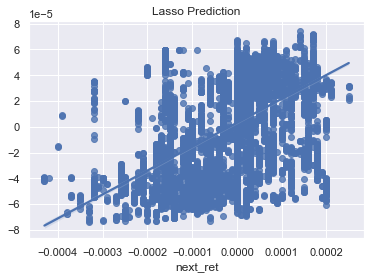

In [58]:
model_lasso = linear_model.LassoCV().fit(X_train_pkl, y_train_pkl) #x-validation
y_pred_lasso = model_lasso.predict(X_test_pkl)
r2_lasso = model_lasso.score(X_test_pkl, y_test_pkl) * 100
rmse_lasso = math.sqrt(mean_squared_error(y_test_pkl,y_pred_lasso))
n_obs = len(y_test_pkl)
n_features = len(X_test_pkl.columns)
log_likelihood_lasso = -0.5 * n_obs * np.log(2 * np.pi) - 0.5 * n_obs * (1 - r2_lasso/100)
AIC_lasso = 2 * (n_features + 1) - 2 * log_likelihood_lasso
BIC_lasso = np.log(n_obs) * (n_features + 1) - 2 * log_likelihood_lasso


ax = sns.regplot(x=y_test_pkl, y=y_pred_lasso)
ax.set_title("Lasso Prediction")
print(f"R2 Lasso: {r2_lasso:.4f}%")
print(f"RMSE Lasso: {rmse_lasso:.6f}")
print("AIC:", AIC_lasso)
print("BIC:", BIC_lasso)

Nous avons obtenu un R2 d'un peu moins de 19.5%, ce qui nous permet de dire que notre modèle est "assez" bien expliqué par les variables explicatives. Concernant la RMSE (racine de l'erreur quadratique moyenne), elle est de 7.7 * 10^(-4), qui est aussi assez faible et permet de dire que notre ajustement semble correct.

<AxesSubplot:title={'center':'Lasso Coef'}>

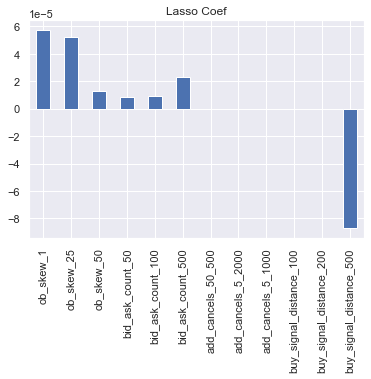

In [59]:
pd.Series(model_lasso.coef_, model_lasso.feature_names_in_).plot.bar(title="Lasso Coef")

Le graphique des coefficients lasso montre que les variables ob_skew_1 et ob_skew_25 ont les plus grands impacts positifs sur la sortie du modèle, tandis que buy_signal_distance_500 a un impact négatif significatif. Les autres variables ont des coefficients proches de zéro, indiquant un impact moindre sur le modèle. Cela suggère que ob_skew est crucial pour les prédictions, alors que buy_signal_distance_500 réduit fortement la sortie du modèle.

#### Ridge

Le modèle de régression ridge est utilisée pour réduire le surajustement et améliorer la généralisation des modèles linéaires. Contrairement à la régression OLS , la régression ridge ajoute une pénalité sur la somme des carrés des coefficients de régression. Cette pénalité est proportionnelle au carré de la magnitude des coefficients, ce qui contraint les coefficients à rester petits. Cela permet de réduire la variance du modèle tout en maintenant une certaine quantité de biais, ce qui conduit à une meilleure performance sur les données de test. 

R2 Ridge: 19.7690%
RMSE Rdige: 0.000077
AIC: 55087.097885985204
BIC: 55190.38742307141


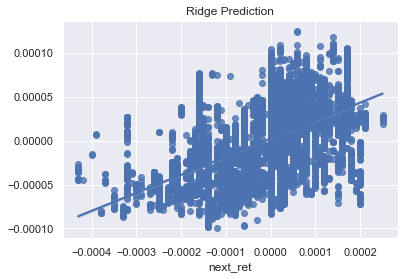

In [60]:
model_ridge = linear_model.RidgeCV().fit(X_train_pkl, y_train_pkl)
y_pred_ridge = model_ridge.predict(X_test_pkl)
r2_ridge = model_ridge.score(X_test_pkl, y_test_pkl) * 100
rmse_ridge = math.sqrt(mean_squared_error(y_test_pkl,y_pred_ridge))
n_obs = len(y_test_pkl)
n_features = len(X_test_pkl.columns)
log_likelihood_ridge = -0.5 * n_obs * np.log(2 * np.pi) - 0.5 * n_obs * (1 - r2_ridge/100)
AIC_ridge = 2 * (n_features + 1) - 2 * log_likelihood_ridge
BIC_ridge = np.log(n_obs) * (n_features + 1) - 2 * log_likelihood_ridge

ax = sns.regplot(x=y_test_pkl, y=y_pred_ridge)
ax.set_title("Ridge Prediction")


print(f"R2 Ridge: {r2_ridge:.4f}%")
print(f"RMSE Rdige: {rmse_ridge:.6f}")
print("AIC:", AIC_ridge)
print("BIC:", BIC_ridge)

Nous avons obtenu un R2 d'un peu plus de 19.5%, ce qui nous permet de dire que notre modèle est "assez" bien expliqué par les variables explicatives. Concernant la RMSE (racine de l'erreur quadratique moyenne), elle est de 7.7 * 10^(-4), qui est aussi assez faible et permet de dire que notre ajustement semble correct.

<AxesSubplot:title={'center':'Ridge Coef'}>

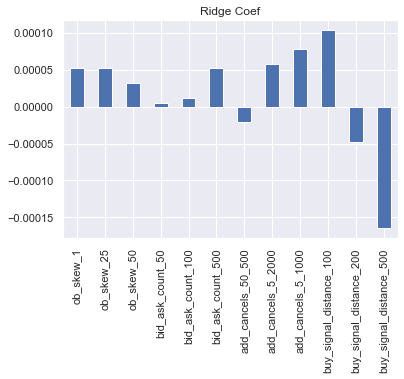

In [61]:
pd.Series(model_ridge.coef_, model_ridge.feature_names_in_).plot.bar(title="Ridge Coef")

Le graphique des coefficients obtenus via la méthde de régresssion ridge nous montre que les variables ob_skew_1, ob_skew_25, add_cancels_5_1000 et buy_singal_distance_100 ont des impacts positifs significatifs sur la sortie du modèle, tandis que buy_signal_distance_500 a un impact négatif notable. Les autres variables ont des impacts variés mais généralement plus faibles. Cela indique que les caractéristiques de l'asymétrie et certaines annulations de commandes sont cruciales pour les prédictions, alors que le signal d'achat par la différence entre mid et moyenne mobile (sur 200 et 500jours) sur une grande distance réduit fortement la sortie du modèle, à contraire du CT avec la variable buy_signal_100 qui est positif et significative.

#### Elastic net

L'elastic net est une méthode de régression qui combine mixe l'élément de pénalité via lasso et la pénalité de ridge dans un seul modèle. Cette régression est utilisée pour régulariser les modèles linéaires et sélectionner les variables importantes tout en réduisant le surajustement. Ce modèle agit en minimisant une fonction de perte qui comprend à la fois les termes de régularisation lasso et ridge, ce qui permet de bénéficier des avantages de chaque méthode. En ajustant les paramètres de régularisation, on peut contrôler le compromis entre la réduction de la variance (réduction du surajustement) et la sélection de caractéristiques. L'elastic net est particulièrement utile lorsque les données présentent une multicollinéarité et lorsqu'il y a un grand nombre de caractéristiques potentielles, tout comme on peut l'observer via la corrélation entre certaines de nos variables (comme ob_skew -> feature 1)

R2 ElasticNet: 19.4893%
RMSE ElasticNet: 0.000077
AIC: 55145.43720720446
BIC: 55248.72674429066


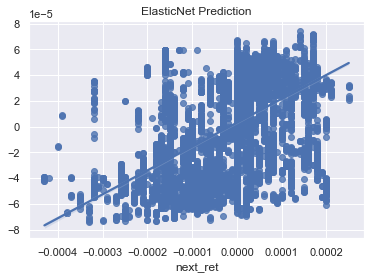

In [62]:
model_elastic_net = linear_model.ElasticNetCV().fit(X_train_pkl, y_train_pkl)
y_pred_elastic_net = model_elastic_net.predict(X_test_pkl)
r2_elastic_net = model_elastic_net.score(X_test_pkl, y_test_pkl) * 100
rmse_elastic_net = math.sqrt(mean_squared_error(y_test_pkl,y_pred_elastic_net))
n_obs = len(y_test_pkl)
n_features = len(X_test_pkl.columns)
log_likelihood_EN = -0.5 * n_obs * np.log(2 * np.pi) - 0.5 * n_obs * (1 - r2_elastic_net/100)
AIC_elastic_net = 2 * (n_features + 1) - 2 * log_likelihood_EN
BIC_elastic_net = np.log(n_obs) * (n_features + 1) - 2 * log_likelihood_EN



ax = sns.regplot(x=y_test_pkl, y=y_pred_elastic_net)
ax.set_title("ElasticNet Prediction")



print(f"R2 ElasticNet: {r2_elastic_net:.4f}%")
print(f"RMSE ElasticNet: {rmse_elastic_net:.6f}")
print("AIC:", AIC_elastic_net)
print("BIC:",BIC_elastic_net)

Nous avons obtenu un R2 d'un peu moins de 19.5%, ce qui nous permet de dire que notre modèle est "assez" bien expliqué par les variables explicatives. Concernant la RMSE (racine de l'erreur quadratique moyenne), elle est de 7.7 * 10^(-4), qui est aussi assez faible et permet de dire que notre ajustement semble correct.

<AxesSubplot:title={'center':'Elastic Coef'}>

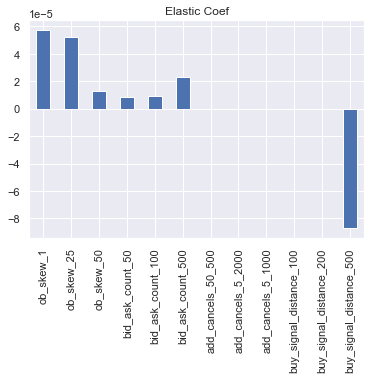

In [63]:
pd.Series(model_elastic_net.coef_, model_elastic_net.feature_names_in_).plot.bar(title="Elastic Coef")

Le graphique des coefficients elastic Net montre que les variables ob_skew_1 et ob_skew_25 ont les impacts positifs les plus importants sur la sortie du modèle, suggérant que ces mesures de l'asymétrie sont cruciales pour les prédictions. En revanche, buy_signal_distance_500 a un impact négatif significatif, indiquant que ce signal d'achat réduit fortement la sortie du modèle. Enfin les autres variables sont peu significatives ou égales à 0.

#### Decision Tree


Un arbre de décision est un algorithme d'apprentissage automatique utilisé pour prendre des décisions en formulant une série de questions basées sur les caractéristiques des données. Chaque nœud de l'arbre représente une question sur une caractéristique, et chaque branche représente une réponse à cette question. L'arbre de décision divise récursivement l'espace des caractéristiques en sous-ensembles plus petits jusqu'à ce qu'il atteigne une condition d'arrêt, telle qu'une profondeur maximale (max_depth=3 ici), un nombre minimum d'échantillons dans un nœud (min_samples_leaf = 20 iic) dans un nœud.  Cependant, il est important de souligner que les arbres de décisoons sont sensibles au surajustement.

R2 Decision Tree: 17.3995%
RMSE Decision Tree: 0.000078
AIC: 55581.25616566404
BIC: 55684.54570275024
R2_Decision Tree w/train: 21.506074%


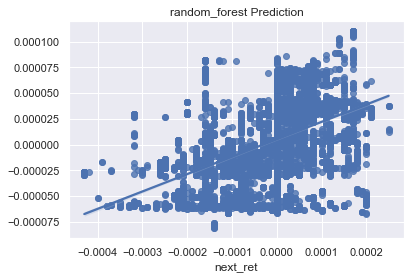

In [64]:
# Hyper-parameters have been tweaked on train data only.
# On a modifié les paramètres l'arbre pour se rapprocher d'un r2 de la regression linéaire afin d'éviter d'overfitter
# notre arbre.

model_random_forest = ensemble.RandomForestRegressor(n_estimators=500, max_features=5, max_depth=3, min_samples_leaf=20).fit(X_train_pkl, y_train_pkl)
y_pred_decision_tree = model_random_forest.predict(X_test_pkl)
r2_decision_tree = model_random_forest.score(X_test_pkl, y_test_pkl) * 100
rmse_decision_tree = math.sqrt(mean_squared_error(y_test_pkl,y_pred_decision_tree))
n_obs = len(y_test_pkl)
n_features = len(X_test_pkl.columns)
log_likelihood_decision_tree = -0.5 * n_obs * np.log(2 * np.pi) - 0.5 * n_obs * (1 - r2_decision_tree/100)
AIC_decision_tree = 2 * (n_features + 1) - 2 * log_likelihood_decision_tree
BIC_decision_tree = np.log(n_obs) * (n_features + 1) - 2 * log_likelihood_decision_tree


ax = sns.regplot(x=y_test_pkl, y=y_pred_decision_tree)
ax.set_title("random_forest Prediction")



print(f"R2 Decision Tree: {r2_decision_tree:.4f}%")
print(f"RMSE Decision Tree: {rmse_decision_tree:.6f}")
print("AIC:", AIC_decision_tree)
print("BIC:", BIC_decision_tree)
print(f'R2_Decision Tree w/train: {model_random_forest.score(X_train_pkl, y_train_pkl) * 100:4f}%')

Nous avons obtenu un R2 d'un peu moins de 17.5%, ce qui nous permet de dire que notre modèle est "assez" bien expliqué par les variables explicatives. Concernant la RMSE (racine de l'erreur quadratique moyenne), elle est de 7.8 * 10^(-4), qui est aussi assez faible et permet de dire que notre ajustement semble correct. Concernant le calcul du R2 avec les données train, nous pouvons constater qu'il existe q'un petit écart entre le R2 sur les données test et train, donc à priori peu d'overfiting et que les données se généralisent assez bien sur les données test.

#### Decision gradient boost

Le gradient boosting cecision tree (GBDT) a pour but de construire un modèle prédictif en utilisant un ensemble de modèles de base, généralement des arbres de décision faibles, de manière itérative. L'idée principale derrière ce modèle est d'ajuster séquentiellement les modèles de base pour corriger les erreurs de prédiction faites par les modèles précédents. À chaque itération, un nouvel arbre de décision est ajouté à l'ensemble pour prédire les résidus du modèle précédent. Les prédictions de tous les arbres sont ensuite agrégées pour produire une prédiction finale. Efnin, ce modèle a pour but de générer un modèle prédictif de haute précision, mais qui peut etre sensible au surajustement.

R2 DGB: 12.5449%
RMSE DGB: 0.000080
AIC: 56593.677007690916
BIC: 56696.96654477712
R2 DGB w/train: 44.074419%


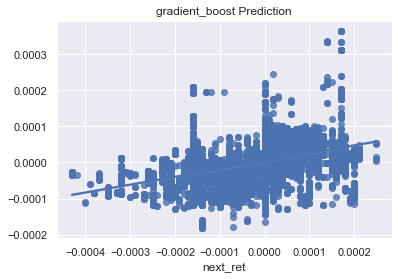

In [65]:
# Hyper-parameters have been tweaked on train data only.
model_dgb= ensemble.GradientBoostingRegressor().fit(X_train_pkl, y_train_pkl)
y_pred_dgb = model_dgb.predict(X_test_pkl)
r2_dgb = model_dgb.score(X_test_pkl,y_test_pkl) * 100
rmse_dgb = math.sqrt(mean_squared_error(y_test_pkl,y_pred_dgb))
n_obs = len(y_test_pkl)
n_features = len(X_test_pkl.columns)
log_likelihood_dgb = -0.5 * n_obs * np.log(2 * np.pi) - 0.5 * n_obs * (1 - r2_dgb/100)
AIC_dgb = 2 * (n_features + 1) - 2 * log_likelihood_dgb
BIC_dgb = np.log(n_obs) * (n_features + 1) - 2 * log_likelihood_dgb


ax = sns.regplot(x=y_test_pkl, y=y_pred_dgb)
ax.set_title("gradient_boost Prediction")


print(f"R2 DGB: {r2_dgb:.4f}%")
print(f"RMSE DGB: {rmse_dgb:.6f}")
print("AIC:", AIC_dgb)
print("BIC:", BIC_dgb)
print(f'R2 DGB w/train: {model_dgb.score(X_train_pkl, y_train_pkl) * 100:4f}%')

Comme nous pouvons le constater, nous avons obtenu un R2 de moins de 13%, ce qui est bien inférieure à l'ensemble de nos modèles. De plus la différence entre le R2 train et R2 test est de plus de 30%, qui suggère donc que modèle DGB est overfitté aux données train (sur apprentissage), en apprenant par coeur les réponses des données trains et donc généralise "assez mal" sur les données test.


### Interprétation de nos différents modèles

#### Méthode basé sur les scores

In [66]:
scores = {
    "r2_MCO": r2_MCO,
    "r2_linear_PCA": r2_PCA,
    "r2_lasso": r2_lasso,
    "r2_ridge": r2_ridge,
    "r2_elasticnet": r2_elastic_net,
    "r2_decision_tree": r2_decision_tree,
    "r2_decision_gradient_boost": r2_dgb
}


df_scores = pd.DataFrame(list(scores.items()), columns=['Model', 'Score'])
df_sorted_scores = df_scores.sort_values(by='Score', ascending=False)
df_sorted_scores.reset_index(drop=True, inplace=True)
df_sorted_scores

Model      Score
0                    r2_ridge  19.769016
1                      r2_MCO  19.762183
2               r2_linear_PCA  19.762183
3                    r2_lasso  19.489330
4               r2_elasticnet  19.489278
5            r2_decision_tree  17.399521
6  r2_decision_gradient_boost  12.544949

Les scores R2 représentent la proportion de la variance des valeurs cibles expliquée par chaque modèle. Les modèles ridge, MCO et linear PCA obtiennent des scores R2 similaires autour de 19.76%, suivis par les méthodes lasso et elastic-nett avec des scores légèrement inférieurs. Les modèles basés sur les arbres, tels que arbrre de décison et DGB montrent des performances légèrement moins bonnes, avec des scores R2 de 17.47% et 12.33% respectivement. 

En conclusion, les modèles de régression régularisés (ridge, MCO) semblent mieux performer que les modèles basés sur les arbres (arbre de décissions et DGB) sur cet ensemble de données. 

Nous pensons que ces différences sont liés aux données hautes-fréquences. Les relations sont extrêmements bruyantes et les modèles linéaires permettent de conserver l'essentiel d'une relation alors que les modèles non-linéaires sont sujets à un sur-apprentissage sur du bruit. Un nombre très élevé d'observations permettrait de palier à ce problème mais cela demanderai de très grosses puissances de calcul.

In [67]:
rmse = {
    "rmse_MCO": rmse_MCO,
    "rmse_linear_PCA": rmse_PCA,
    "rmse_lasso": rmse_lasso,
    "rmse__ridge": rmse_ridge,
    "rmse_elasticnet": rmse_elastic_net,
    "rmse_decision_tree": rmse_decision_tree,
    "rmse_decision_gradient_boost": rmse_dgb
}


df_rmse = pd.DataFrame(list(rmse.items()), columns=['Model', 'RMSE'])
df_sorted_rmse = df_rmse.sort_values(by='RMSE', ascending=True)
df_sorted_rmse.reset_index(drop=True, inplace=True)
df_sorted_rmse

Model      RMSE
0                   rmse__ridge  0.000077
1                      rmse_MCO  0.000077
2               rmse_linear_PCA  0.000077
3                    rmse_lasso  0.000077
4               rmse_elasticnet  0.000077
5            rmse_decision_tree  0.000078
6  rmse_decision_gradient_boost  0.000080

In [68]:
BIC = {
    "BIC_MCO": BIC_MCO,
    "BIC_linear_PCA": BIC_PCA,
    "BIC_lasso": BIC_lasso,
    "BIC__ridge": BIC_ridge,
    "BIC_elasticnet": BIC_elastic_net,
    "BIC_decision_tree": BIC_decision_tree,
    "BIC_decision_gradient_boost": BIC_dgb
}


df_BIC = pd.DataFrame(list(BIC.items()), columns=['Model', 'BIC'])
df_sorted_BIC = df_BIC.sort_values(by='BIC', ascending=True)
df_sorted_BIC.reset_index(drop=True, inplace=True)
df_sorted_BIC

Model           BIC
0                   BIC__ridge  55190.387423
1                      BIC_MCO  55191.812493
2               BIC_linear_PCA  55191.812493
3                    BIC_lasso  55248.716065
4               BIC_elasticnet  55248.726744
5            BIC_decision_tree  55684.545703
6  BIC_decision_gradient_boost  56696.966545

In [69]:
AIC = {
    "AIC_MCO": AIC_MCO,
    "AIC_linear_PCA": AIC_PCA,
    "AIC_lasso": AIC_lasso,
    "AIC__ridge": AIC_ridge,
    "AIC_elasticnet": AIC_elastic_net,
    "AIC_decision_tree": AIC_decision_tree,
    "AIC_decision_gradient_boost": AIC_dgb
}


df_AIC = pd.DataFrame(list(AIC.items()), columns=['Model', 'AIC'])
df_sorted_AIC = df_AIC.sort_values(by='AIC', ascending=True)
df_sorted_AIC.reset_index(drop=True, inplace=True)
df_sorted_AIC

Model           AIC
0                   AIC__ridge  55087.097886
1                      AIC_MCO  55088.522956
2               AIC_linear_PCA  55088.522956
3                    AIC_lasso  55145.426528
4               AIC_elasticnet  55145.437207
5            AIC_decision_tree  55581.256166
6  AIC_decision_gradient_boost  56593.677008

Le RMSE (root mean squared error) mesure l'écart moyen entre les valeurs prédites par le modèle et les valeurs réelles de la variable cible. Il est exprimé dans la même unité que la variable cible et le plus faible est le meilleur (minilisation). Dans cet ensemble de résultats, tous les modèles ont des valeurs RMSE très similaires autour de 0.000077, ce qui indique une bonne performance de prédiction avec une faible erreur. En effet, en termes d'ordre, les résultats sont similaire à ceux des R2

L'AIC (Akaike Information Criterion) et le BIC (Bayesian Information Criterion) sont des critères d'évaluation qui prennent en compte la qualité du modèle et sa complexité. Ils sont utilisés pour comparer différents modèles et sélectionner celui qui explique le mieux les données tout en étant le moins complexe. Un AIC ou BIC plus faible indique un meilleur ajustement du modèle aux données. Dans cet ensemble de résultats, les modèles MCO et rridge ont les valeurs les plus basses pour AIC et BIC, ce qui suggère qu'ils sont les modèles les plus appropriés pour expliquer les données tout en évitant la complexité excessive.

#### SHAP


SHAP est une méthode pour expliquer les prédictions des modèles de machine learning visant à attribuer de manière équitable l'impact de chaque feature sur les prédictions. Ses valeurs déterminent la contribution de chaque feature à la prédiction d'un modèle en comparant les prédictions avec et sans cette feature. Cette mesure va nous permettre de comprendre et interpréter notre modèle de prédiction puisqe cela va nous aider à visualiser et quantifier comment chaque feature influence les prédictions, afin d'avoir des informations sur les différentes features de notre modèle.


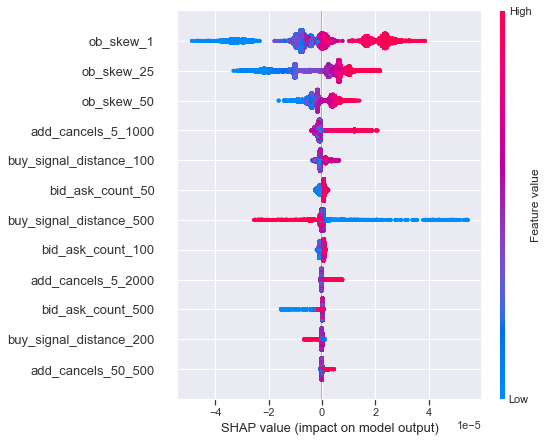

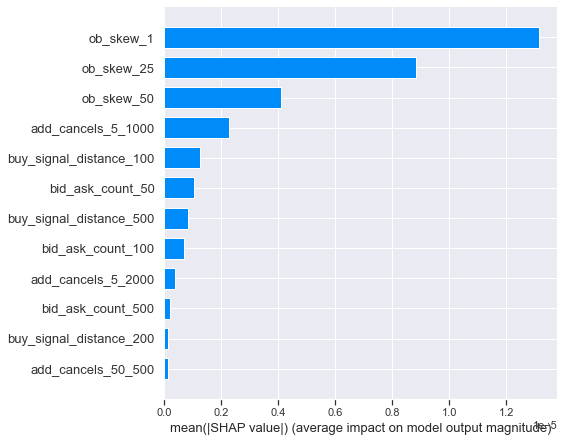

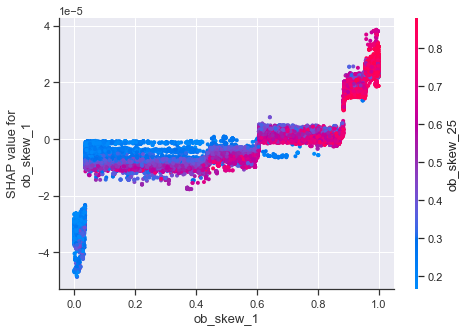

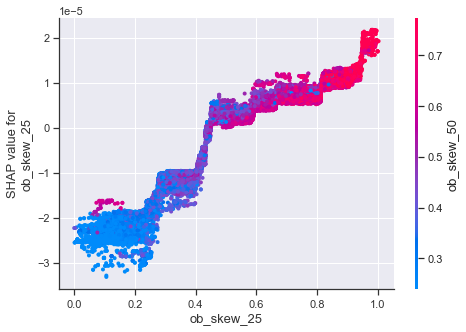

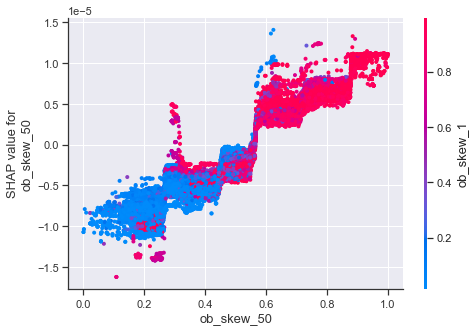

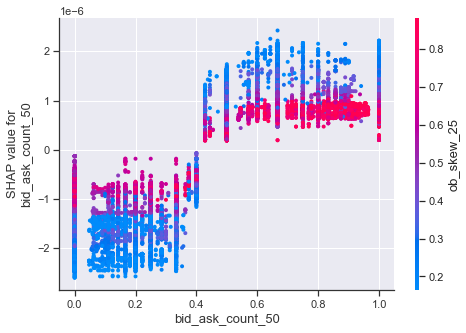

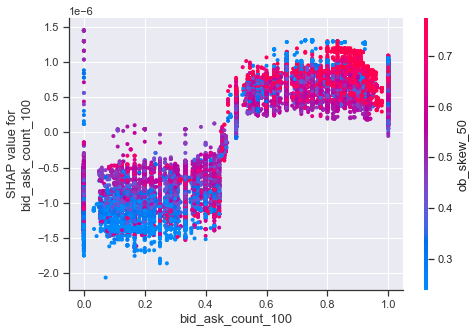

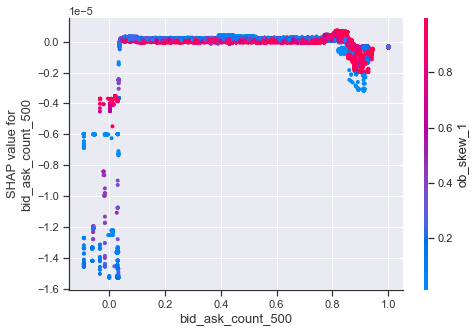

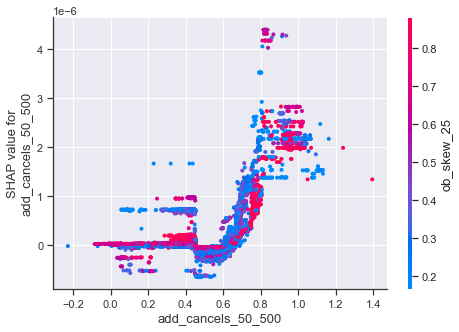

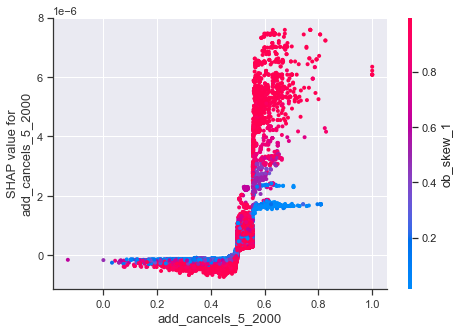

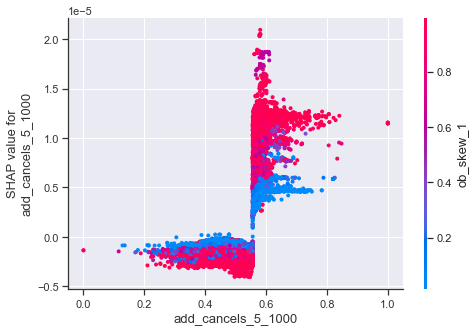

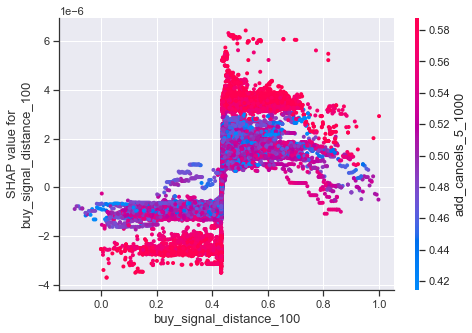

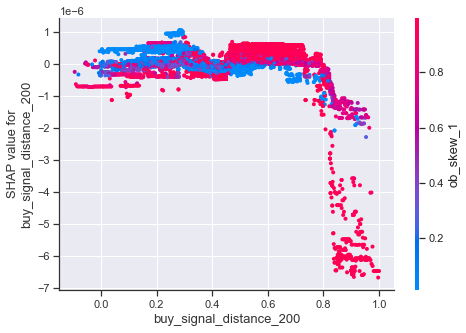

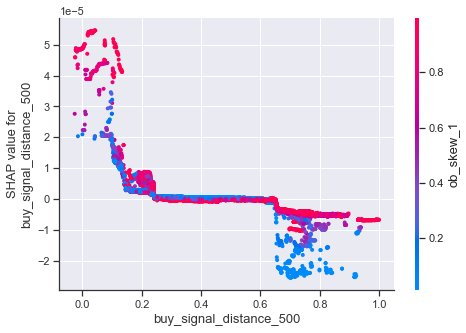

In [70]:
explainer_model = shap.TreeExplainer(model_random_forest)
shap_values_model = explainer_model.shap_values(X)
#shap_values = explainer.shap_values(X_train_pkl)
expected_value = explainer_model.expected_value
 
# graph:

# summary
shap.summary_plot(shap_values_model, X,title="SHAP summary plot")
#shap.summary_plot(shap_values, X_train_pkl,title="SHAP summary plot")

# histo bar plot
shap.summary_plot(shap_values_model, X,plot_type="bar")
# shap.summary_plot(shap_values, X_train_pkl,plot_type="bar")

# dependencee plot
for name_features in xcols:
     shap.dependence_plot(name_features, shap_values_model, X)
    #     shap.dependence_plot(name, shap_values, X_train_pkl)

La première figure présente l'importance globale des variables en utilisant les valeurs de SHAP, en mettant en évidence quelles features sont les plus influentes dans le modèle et voir si des valeurs élevées ou basses de chaque features tendent à augmenter ou baisser la prédiciton de notre modèle. Ce graphique montre le résumé des valeurs SHAP où l'axe Y indique les noms des  features par ordre d'importance, et l'axe X représente la valeur SHAP, indiquant l'impact sur la sortie du modèle, soit la variabilité de l'impact de cahque feature sur les predictions. La couleur des points varie du rouge (valeurs élevées) au bleu (valeurs basses), chaque point représentant une ligne de données du jeu de données original. Par exemple, ob_skew_1, la variable la plus importante, a des impacts variés selon sa valeur : des valeurs élevées (points rouges) augmentent la sortie du modèle, tandis que des valeurs basses (points bleus) la diminuent. À l'inverse, pour distance_500, des valeurs élevées (points rouges) tendent à diminuer la sortie du modèle, alors que des valeurs basses (points bleus) tendent à l'augmenter.

Le second graphique nous montre l'importance des valeurs absolues moyennes des SHAP pour chaque feature, indiquant l'impact moyen sur l'amplitude de la sortie du modèle. Ce dernier classe alors les features par ordre d'importance, et permettant d'observer quelles features ont les plus gros impact moyen sur la prédiction, et pour but, d'identifier les features les plus et kes mois importantes. ob_skew_1 est la variable la plus influente, suivie de ob_skew_25 et ob_skew_50, soulignant l'importance des mesures de l'asymétrie de l'ordre book dans les prédictions du modèle. D'autres variables comme add_cancels_5_1000 et distance_100 ont également une influence significative mais moindre. Ce graphique offre une vue claire des variables les plus impactantes, que leur effet soit positif ou négatif.

Ensuite, nous avons les graphes de dépendnaces qui illustrent comment les prédictions du modèle sont affectées par des caractéristiques spécifiques. En effet, il nous montre les interactions potentielles entre nos différntes features, et voir comment une feature peut impacter une autre sur la prediciton du modèle. L'axe X représente la valeur d'une feature et en axe Y sa valeur de SHAP. Cependant la couleur des différents points représente les  valeurs d'une autre feature (nom a droite) afin de detecter les possibles interractions entre les features.



## Conclusion

Le projet visait à prédire le carnet d'ordres des cryptomonnaies (bitcoin) en se basant sur leurs rendements. Après avoir traité les données du carnet d'ordres et des transactions, nous avons exploré différentes approches de modélisation, incluant des modèles simples, non supervisés et supervisés.

Pour rappel, nous avons obtenu que les modèles de régression, notamment ridge, et MCO,,ainsi que le modèle non supervisé de linear PCA qui ont obtenu les meilleurs scores R2 autour de 19.76%. Ces modèles surpassent les modèles basés sur les arbres comme l'arbre de decision et le DGB, qui ont respectivement obtenu des scores R2 de 17.47% et 12.33%. De plus, nous avons aussi vu que modèle DGB montre un fort surajustement, capturant beaucoup de bruits sur les données trains et généralisant mal sur les données test, contrairement à l'arbre de décisio, qui lui fait peur d'overfitting. Enfin, le modèle non supervisé PCA suggérait que deux de nos variables expliquaient 75% de la variance totale des données.

Nous nous sommes rendu compte de la complexité de la tâche car les relations entre notre cible et les features sont extrêmements bruyantes ce qui présente des difficultés pour la calibration des modèles. Ce projet confirme que les données financières sont extrêmemtns durs à traiter et de par leur complexité il est souvent plus sage de favoriser la parcimonie avec un modèle linéaire.

En terme d'ouverture, nous pourrions nous intéresser à d'autres carrnets d'ordre, mais cela ne garanti pas forcément un meillleur résultat étatnt donné que le bticoin est la crypto monnaie la plus liquide. En effet, le travail sur les données bal donne des résultats que très peu prédictifs. Cependant, on pourrait penser à un carnet d'ordre equity qui pourrait peut-être nous donner des résultats plus intéréssants.